# Exploring Molecular Energy Landscapes of Hardware-Efficient Ansätze in Quantum Computing for Carbon Capture

One of the frontrunners for the Noisy Intermediate-Scale Quantum (NISQ) era's practical uses of quantum computers is quantum chemistry. By employing the Hybrid Quantum Classical Optimisation Framework and classical quantum computer training, our research intends to investigate the minimum of the Ground Potential Energy Surface (PES) of $BeH_2$ molecule and later on developing an algorithm that efficiently calculates the minimum of the PES for systems related to $CO_2$ capture using MOFs. We will use Variational Quantum Eigensolver (VQE).

Focus of our study lies in exploring the power of **hardware-efficient ansatzes** and aim to improve the convergence to find the ground state energy of the molecule/ system. We study the latest paper published in this domain: [*Molecular Energy Landscapes of Hardware-Efficient Ansätze* in Quantum Computing by Boy Choy and David J. Wales](https://pubs.acs.org/doi/pdf/10.1021/acs.jctc.2c01057).
They propose a  simple deparameterisation procedure that reduces the trainable parameters while retaining high
accuracy for the global minimum, simplifying the energy landscape, and hence speeding up optimization.

In [1]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit_nature.second_q.circuit.library import UCCSD, UCC, HartreeFock, PUCCD, SUCCD

from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter
from qiskit_nature.second_q.mappers import BravyiKitaevMapper, JordanWignerMapper, ParityMapper

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer

from qiskit_nature.units import DistanceUnit

from qiskit.circuit.library import TwoLocal
from qiskit.circuit import Parameter
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.gradients import FiniteDiffEstimatorGradient
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP, NELDER_MEAD, QNSPSA
from qiskit.algorithms.optimizers.spsa import powerseries
from qiskit.primitives import Estimator, BackendEstimator
from qiskit.utils import algorithm_globals

from qiskit import *
from qiskit.providers.fake_provider import FakeNairobi
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops import TaperedPauliSumOp
from qiskit.providers import Options

from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)

from qiskit_braket_provider import AWSBraketProvider, BraketLocalBackend
from qiskit_aer.noise import NoiseModel
from qiskit.converters import circuit_to_dag, dag_to_circuit
from collections import OrderedDict

import pandas as pd
import numpy as np
import re
import mapomatic as mm
import os
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from fake_backend import update_fake_backend
import importlib
import time

In [2]:
def _import_class(module_and_class_name: str) -> type:
    """Import class from a module, e.g. 'text_recognizer.models.MLP'"""
    module_name, class_name = module_and_class_name.rsplit(".", 1)
    module = importlib.import_module(module_name)
    class_ = getattr(module, class_name)
    return class_

In [3]:
seed = 170
algorithm_globals.random_seed = seed

## VQE with local runtim primitives

To compute the ground state energy using VQE, we first pick an appropriate device. We will **ibmq_nairobi** which has 7 qubits. We will use the FakeNairobi backend for local simulations.

In [4]:
# Get fake backend if you like
noisy_sim = FakeNairobi()
# noise_model = update_fake_backend(noisy_sim, 'ibm_nairobi')

# Real backend; needed for transpilation later on
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='qhack-event', group='main', project='level-1')
nairobi = provider.get_backend("ibm_nairobi")

coupling_map = nairobi.configuration().coupling_map

/tmp/ipykernel_14554/4221913036.py:6: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  provider = IBMQ.load_account()
/tmp/ipykernel_14554/4221913036.py:6: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


## Building helper functions

It would be practical to create a reusable custom function that we can execute to get problem-related items and VQE instances before moving on to more VQE problems.

### Problem construction

This function takes the following arguments:
- `geometry` of the molecule of interest
- `charge` on the molecule
- `spin` of the molecule. In accordance with PySCF’s definition, the spin equals 2*S, where S is the total spin number of the molecule. 
- `basis` is the basis set used for the molecule eg. sto3g, ccpvdz etc.
- `mapper_type`: ParityMapper, JordanWignerMapper, BravyiKitaevMapper
- `num_spatial_orbitals` and `num_electrons` for the Active space transformation. If `num_electrons` are not specified then all the electrons are used.
- `z2symmetry_reduction`indicates whether a z2 symmetry reduction should be applied to resulting qubit operators that are computed. If None, then it is not applied. For more details visit [here](https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.mappers.QubitConverter.html#qiskit_nature.second_q.mappers.QubitConverter)

The function will return a reduced instance of the problem (`problem_reduced`), a `converter` from second-quantized to qubit operators, the `qubit_op` Hamiltonian and the real-solution converged using the statevector simulator (`res_actual`).

In [5]:
def construct_problem(geometry, 
                      charge, 
                      spin, 
                      basis, 
                      mapper_type,
                      num_spatial_orbitals,
                      num_electrons = None, 
                      z2symmetry_reduction=None):
    
    # The spin of the molecule. In accordance with PySCF’s definition, the spin equals 2*S, 
    # where S is the total spin number of the molecule.
    driver = PySCFDriver(
            atom=geometry,
            basis=basis,
            charge=charge,
            spin=int(2*spin),
            unit=DistanceUnit.ANGSTROM,
        )
    
    # Run the preliminary quantum chemistry calculation
    problem = driver.run()
    
    if num_electrons is None:
        num_electrons = problem.num_particles
    
    # Set the active space
    # Define the active space around the Fermi level 
    # (selected automatically around the HOMO and LUMO, ordered by energy)
    transformer = ActiveSpaceTransformer(
        num_electrons=num_electrons, # Number of electrons in our active space
        num_spatial_orbitals=num_spatial_orbitals, # Number of orbitals in our active space
        active_orbitals=None # May be useful
    )
        
    # Now you can get the reduced electronic structure problem
    problem_reduced = transformer.transform(problem)
    
    # The second quantized Hamiltonian of the reduce problem
    second_q_ops_reduced = problem_reduced.second_q_ops()
    
    
    # Setup the mapper and qubit converter
    if mapper_type == 'ParityMapper':
        mapper = ParityMapper()
    elif mapper_type == 'JordanWignerMapper':
        mapper = JordanWignerMapper()
    elif mapper_type == 'BravyiKitaevMapper':
        mapper = BravyiKitaevMapper()
    
    # Set the qubit converter with two qubit reduction to reduce the computational cost 
    converter = QubitConverter(mapper, 
                               two_qubit_reduction=True, 
                               z2symmetry_reduction = z2symmetry_reduction)
    
    # Compute the Hamitonian in qubit form
    qubit_op = converter.convert(second_q_ops_reduced[0], 
                                 num_particles=problem_reduced.num_particles,
                                 sector_locator=problem_reduced.symmetry_sector_locator)
    
    # Get reference solution
    numpy_solver = NumPyMinimumEigensolver()
    calc = GroundStateEigensolver(converter, numpy_solver)
    res_actual = calc.solve(problem_reduced)
    
    return problem_reduced, converter, qubit_op, res_actual

### Problem Ansatz

This function takes the following arguments:
- `ansatz_type` to specify the ansatz of intereset. Here we will focus on Hardware-efficient ansatzes and therefore will use *TwoLocal* as the ansatz_type
- `res` defines the number of the times the ansatz is repeated
- `problem_reduced` reduced instance of the problem obtained from `construct_problem`. 
- `converter` qubit converter obtained from `construct_problem`

The function finds the Hartree fock state and use it as the initial state will return the desired ansatz.

In [6]:
def get_ansatz(ansatz_type, reps, problem_reduced, converter):
    
    # Hartree focks state
    num_particles = problem_reduced.num_particles
    num_spatial_orbitals = problem_reduced.num_spatial_orbitals
    
    init_state = HartreeFock(num_spatial_orbitals=num_spatial_orbitals,
                             num_particles=num_particles,
                             qubit_converter=converter)
    
    # Choose the ansatz
    
    # Put arguments for twolocal
    if ansatz_type == "TwoLocal":
        # Single qubit rotations that are placed on all qubits with independent parameters
        rotation_blocks = ['ry']
        # Entangling gates
        entanglement_blocks = 'cx'
        # How the qubits are entangled 
        entanglement = 'linear'
        # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
        repetitions = reps
        # Skip the final rotation_blocks layer
        skip_final_rotation_layer = False
        ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                          entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
        # Add the initial state
        ansatz.compose(init_state, front=True, inplace=True)
    elif ansatz_type == "UCCSD":
        ansatz = UCCSD(num_spatial_orbitals = num_spatial_orbitals,
                       num_particles = num_particles, 
                       qubit_converter= converter, 
                       reps = reps, 
                       initial_state =init_state)
    elif ansatz_type == "PUCCD":
        ansatz = PUCCD(num_spatial_orbitals = num_spatial_orbitals,
                       num_particles = num_particles, 
                       qubit_converter= converter, 
                       reps = reps, 
                       initial_state =init_state)
    elif ansatz_type == "SUCCD":
        ansatz = SUCCD(num_spatial_orbitals = num_spatial_orbitals,
                       num_particles = num_particles, 
                       qubit_converter= converter, 
                       reps = reps, 
                       initial_state =init_state)
    elif ansatz_type == 'UCC':
        ansatz = UCC(num_spatial_orbitals = num_spatial_orbitals,
                     num_particles = num_particles,
                     qubit_converter= converter, 
                     reps = reps, 
                     initial_state =init_state,
                     excitations='sd')
    
    return ansatz

### Device mapping of ansatz and hamiltonian

Since we are using a 7 qubit device and its possible that the number of qubits used byt the Hamiltonian can be less than 7. This might result in extra qubits than required by the Hamiltonian, so we will need to add identity operators to the Hamiltonian. We also have to map the ansatz to the device. The function below achieves the same

-`ansatz` of the problem.
-`backend` used to simulation
-`qubit_op` is the hamlitonian of the problem.

The function uses [mapomatic](https://github.com/Qiskit-Partners/mapomatic) for automatic mapping of compiled circuits to low-noise sub-graphs. Identity operators are added to the hamiltonian at appropriate qubits. The new ansatz (`ansatz_opt`) and `new_qubit_op` are returned.

In [7]:
def device_mapping(ansatz, backend, qubit_op):
    
    # find qubit layout
    trans_qc = transpile(ansatz, 
                         backend = backend,  
                         optimization_level= 3,
                         seed_transpiler=seed)
    small_qc = mm.deflate_circuit(trans_qc)
    score = mm.best_overall_layout(small_qc, backend)
    
    # Extract the quantum retmgisters from score list
    q_regs = score[0]
    
    q_layout = q_regs

    # fake backend optimal ansatz
    ansatz_opt = transpile(ansatz, 
                           backend=backend, 
                           initial_layout=q_layout, 
                           optimization_level= 3, 
                           seed_transpiler=seed)
    
    # map hamiltonian to backend
    coeff = qubit_op.coeff
    z2_symmetries = qubit_op.z2_symmetries
    
    ops = []
    n_qubits = noisy_sim.configuration().n_qubits

    ancilla_qubits = np.setdiff1d(np.arange(0, n_qubits), q_layout)

    for op in qubit_op:
        pauli_string = op.primitive.paulis[0]

        for i in ancilla_qubits:
            pauli_string = pauli_string.insert(i, Pauli("I"))

        pauli_string = pauli_string.__str__()

        pauli_coeff = op.primitive.coeffs[0]
        ops.append((pauli_string, pauli_coeff))
        
    new_qubit_op = TaperedPauliSumOp(SparsePauliOp.from_list(ops), z2_symmetries, coeff)
    
    return ansatz_opt, new_qubit_op

### Finding a init point multiplier

This is a helper function to find a initial point multiplier in 1 dimension. It finds the constant value array which gives the lowest energy. The function takes

- `ansatz_opt` the desired ansatz used
- `optimizer_type` for the type of optimizer eg. SPSA, L_BFGS_B etc.
- `new_qubit_op` is the hamiltonian for the `ansatz_opt`.

It returns a single value which represent the constant value of the array. For example if the value returned is 2.03 then the initial point [2.03, 2.03 ...... 2.03]

In [8]:
def init_point_finder(ansatz_opt, optimizer_type, new_qubit_op):
    inits = np.linspace(-np.pi,np.pi,50)
    values = []
    
    for i in range(len(inits)):
        try:
            initial_point = [inits[i]] * len(ansatz_opt.ordered_parameters)
        except:
            initial_point = [inits[i]] * ansatz_opt.num_parameters
            
        estimator = Estimator(options={'seed':seed,"seed_transpiler": seed,"optimization_level":0})

        opt = _import_class(f"qiskit.algorithms.optimizers.{optimizer_type}")(maxiter=0)

        vqe = VQE(estimator, ansatz_opt, opt, initial_point=initial_point)
        result = vqe.compute_minimum_eigenvalue(operator=new_qubit_op)

        intermediate_info = []
        five_percent = []
        one_percent = []
        ev = result.eigenvalue
        values.append(ev)
        l = len(values)
        clear_output(wait=True)
        plt.ylabel('Energy')
        plt.xlabel('init_point')
        plt.plot(inits[:l], values, color='purple', lw=2, label='Simulated VQE')
        plt.legend()
        plt.grid()
        plt.show()

    idx = np.where(values <= min(values))[0]
    
    return inits[idx][0]

### Custom VQE

We define a `custom_vqe` function to handle the VQE routine. The function takes
- `estimator` which is the qiskit primitive Estimator object
- `ansatz_opt` is the desired ansatz
- `optimizer` is the chosen optimizer for the VQE
- `new_qubit_op` hamiltonian
- `exact_energy` represents the exact energy obtained from the statevector simulation
- `execution` defines the type of execution. Here we use only 'local' execution.
- `multiplier` is the constant value obatined from the `init_point_finder` function.
- `init_point` is the user defined inital point.

The function performs the VQE routine and returns the `result` of the algorithm and `intermediate_info` which contains the values of the cost function at every iteration.

In [9]:
def custom_vqe(estimator, 
               ansatz_opt, 
               optimizer, 
               new_qubit_op,  
               exact_energy,
               execution = 'local',
               multiplier = None,
               init_point = None):
    
    # Define a simple callback function
    intermediate_info = []
    five_percent = []
    one_percent = []

    def callback(eval_count, parameters, value, std):
        intermediate_info.append(value)
        five_percent.append(exact_energy*(1-0.05))
        one_percent.append(exact_energy*(1-0.01))
        clear_output(wait=True)
        plt.plot(intermediate_info, color='purple', lw=2, label=f'Simulated VQE {np.round(value,4)}')
        plt.ylabel('Energy')
        plt.xlabel('Iterations')
        # Exact ground state energy value
        plt.axhline(y=exact_energy,color="tab:red",ls="--", lw=2,label="Target: "+str(np.round(exact_energy,4)))
        plt.plot(five_percent, lw=1, label=f'5% ({np.round(exact_energy*(1-0.05),4)})')
        plt.plot(one_percent, lw=1, label=f'1% ({np.round(exact_energy*(1-0.01),4)})')
        plt.legend()
        plt.grid()
        plt.show()
    
    
    def callback_sim(eval_count, parameters, value, std):
        intermediate_info.append(value)
        five_percent.append(exact_energy*(1-0.05))
        one_percent.append(exact_energy*(1-0.01))
    
    if multiplier == None:
        try:
            initial_point = np.random.uniform(size=(len(ansatz_opt.ordered_parameters)))
        except:
            initial_point = np.random.uniform(size=ansatz_opt.num_parameters)
    else:
        try:
            initial_point = [multiplier] * len(ansatz_opt.ordered_parameters)
        except:
            initial_point = [multiplier] * ansatz_opt.num_parameters
            
    
    if init_point is not None:
        initial_point = init_point
    
    if execution == 'local':
        gradient = FiniteDiffEstimatorGradient(estimator, epsilon=0.001)
        vqe = VQE(estimator, 
                  ansatz_opt, 
                  optimizer, 
                  callback=callback, 
                  gradient=gradient, 
                  initial_point=initial_point)
        result = vqe.compute_minimum_eigenvalue(operator=new_qubit_op)
    else:
        service = QiskitRuntimeService(channel='ibm_quantum')
        backend = 'aer_simulator'
        with Session(service=service, backend=backend) as session:
            
            # Prepare primitive
            rt_estimator = RuntimeEstimator(session=session)
            # Set up algorithm

            gradient = FiniteDiffEstimatorGradient(rt_estimator, epsilon=0.001)
            vqe = VQE(rt_estimator, 
                      ansatz_opt, 
                      optimizer, 
                      callback=callback_sim, 
                      gradient=gradient, 
                      initial_point=initial_point)

            # Run algorithm
            result = vqe.compute_minimum_eigenvalue(operator=new_qubit_op)
    
    return result, intermediate_info

## Utilities

The `get_optimizer` function returns a classical optimizer based on the `optimizer_type`. 

- `optimizer_type` is the type of the optimizer used
- `max_iter` is the maximum number of iterations for the optmizer
- `a` is the learning rate specifically for SPSA optimizer
- `c` is the perturbation specifically for SPSSA optimizer

In [10]:
def get_optimizer(optimizer_type, max_iter = 50, a = 0.1, c = 0.1):
    maxiter= max_iter
    stability_constant = 1
    c = c
    alpha = 0.602
    gamma = 0.101

    a = a

    # set up the powerseries
    def learning_rate():
        return powerseries(a, alpha, stability_constant)

    def perturbation():
        return powerseries(c, gamma)

    if optimizer_type == 'SPSA':
        optimizer = SPSA(maxiter=maxiter,
                         learning_rate=learning_rate, 
                         perturbation=perturbation)
    elif optimizer_type == 'SLSQP':
        optimizer = SLSQP(maxiter=maxiter)
    elif optimizer_type == 'NELDER_MEAD':
        optimizer = NELDER_MEAD(maxiter=maxiter)
    elif optimizer_type == 'L_BFGS_B':
        optimizer = L_BFGS_B(maxiter=maxiter)
        
    return optimizer

The `rel_err` function calculates the relative error between the `measured` and `target` value.

In [11]:
def rel_err(target, measured):
    return abs((target - measured) / target)

In [32]:
def display_mapper(mapper, qubit_op, res_actual):
    print(mapper)
    print("Number of Hamiltonian terms:", len(qubit_op))
    print("Number of qubits required:", qubit_op.num_qubits)
    print()
    print("* Electronic ground state energy (Hartree):", res_actual.electronic_energies[0])
    print("\t- computed part:",res_actual.eigenvalues[0])
    print("\t- ActiveSpaceTransformer extracted energy part:", 
          res_actual.extracted_transformer_energies['ActiveSpaceTransformer'])
    print("~ Nuclear repulsion energy (Hartree):",res_actual.nuclear_repulsion_energy)
    print("> Total ground state energy (Hartree):",res_actual.total_energies[0])
    print('-'*50)

In [12]:
def remove_idle_qwires(circ):
    dag = circuit_to_dag(circ)

    idle_wires = list(dag.idle_wires())
    for w in idle_wires:
        dag._remove_idle_wire(w)
        dag.qubits.remove(w)

    dag.qregs = OrderedDict()

    return dag_to_circuit(dag)

## Molecule Beryllium hydride

$BeH_2$ is an alkaline earth hydride with 6 electrons. A full simulation of this molecule for finding the ground state energy will require 14 qubits. We will limit ourselves with 4 active electrons and 4 spatial orbitals and freeze the core. We first try to see which fermionic to qubit mapping has the lowest number of hamiltonian terms and uses the least number of qubits.

In [35]:
beh2 = f"H -0.1129 0.3052 0.0000 ; Be 1.0381 -0.3601 0.0000 ; H 2.1898 -1.0243 0.0000"

S = 0
charge = 0
basis = "sto3g"
num_electrons = 4
num_spatial_orbitals = 4 # encodes eight spin orbitals

In [36]:
mappers = ['ParityMapper', 'JordanWignerMapper', 'BravyiKitaevMapper']
mappers_dict = {}
for mapper in mappers:
    z2symmetry_reduction = None
    _, _, qubit_op, res_actual = construct_problem( beh2, 
                                                  charge, 
                                                  S, 
                                                  basis, 
                                                  mapper,
                                                  num_spatial_orbitals,
                                                  num_electrons, 
                                                  z2symmetry_reduction=z2symmetry_reduction)
    mappers_dict[mapper] = [qubit_op, res_actual]

In [37]:
print("No z2 symmetry reduction\n")
for mapper, (qubit_op, res_actual) in mappers_dict.items():
    display_mapper(mapper, qubit_op, res_actual)

No z2 symmetry reduction

ParityMapper
Number of Hamiltonian terms: 135
Number of qubits required: 6

* Electronic ground state energy (Hartree): -18.949323143851363
	- computed part: -3.917749148316193
	- ActiveSpaceTransformer extracted energy part: -15.031573995535169
~ Nuclear repulsion energy (Hartree): 3.383298951396407
> Total ground state energy (Hartree): -15.566024192454956
--------------------------------------------------
JordanWignerMapper
Number of Hamiltonian terms: 149
Number of qubits required: 8

* Electronic ground state energy (Hartree): -18.949323143851352
	- computed part: -3.917749148316172
	- ActiveSpaceTransformer extracted energy part: -15.03157399553518
~ Nuclear repulsion energy (Hartree): 3.383298951396407
> Total ground state energy (Hartree): -15.566024192454945
--------------------------------------------------
BravyiKitaevMapper
Number of Hamiltonian terms: 149
Number of qubits required: 8

* Electronic ground state energy (Hartree): -18.949323143851363

In [38]:
mappers_dict = {}
for mapper in mappers:
    z2symmetry_reduction = 'auto'
    _, _, qubit_op, res_actual = construct_problem( beh2, 
                                                  charge, 
                                                  S, 
                                                  basis, 
                                                  mapper,
                                                  num_spatial_orbitals,
                                                  num_electrons, 
                                                  z2symmetry_reduction=z2symmetry_reduction)
    mappers_dict[mapper] = [qubit_op, res_actual]

In [39]:
print("With auto z2 symmetry reduction\n")
for mapper, (qubit_op, res_actual) in mappers_dict.items():
    display_mapper(mapper, qubit_op, res_actual)

With auto z2 symmetry reduction

ParityMapper
Number of Hamiltonian terms: 119
Number of qubits required: 5

* Electronic ground state energy (Hartree): -18.949323143851363
	- computed part: -3.917749148316193
	- ActiveSpaceTransformer extracted energy part: -15.031573995535169
~ Nuclear repulsion energy (Hartree): 3.383298951396407
> Total ground state energy (Hartree): -15.566024192454956
--------------------------------------------------
JordanWignerMapper
Number of Hamiltonian terms: 119
Number of qubits required: 5

* Electronic ground state energy (Hartree): -18.94932314385134
	- computed part: -3.9177491483161675
	- ActiveSpaceTransformer extracted energy part: -15.031573995535174
~ Nuclear repulsion energy (Hartree): 3.383298951396407
> Total ground state energy (Hartree): -15.566024192454934
--------------------------------------------------
BravyiKitaevMapper
Number of Hamiltonian terms: 119
Number of qubits required: 5

* Electronic ground state energy (Hartree): -18.9493231

### Results with and without z2 symmetry reduction

As we can see that without any z2 symmetry reduction, `ParityMapper` has the lowest number of hamiltonian terms (135) and also the least number of qubits used (6). Upon using the z2 symmetry reduction, all the mappers as the same number of terms in their hamiltonian (119) and the same number of qubits (5). Without loss of generality, we use the `ParityMapper` with z2 symmetry reduction for our computations.

In [40]:
mapper_type = 'ParityMapper'
z2symmetry_reduction = 'auto'

problem_reduced, converter, qubit_op, res_actual = construct_problem( beh2, 
                                                                      charge, 
                                                                      S, 
                                                                      basis, 
                                                                      mapper,
                                                                      num_spatial_orbitals,
                                                                      num_electrons, 
                                                                      z2symmetry_reduction=z2symmetry_reduction)

In [41]:
len(qubit_op), qubit_op.num_qubits

(119, 5)

In [42]:
exact_energy = res_actual.eigenvalues[0]
print(f'Expected ground state energy: {exact_energy:.12f}')
print(res_actual)

Expected ground state energy: -3.917749148316
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -18.949323143851
  - computed part:      -3.917749148316
  - ActiveSpaceTransformer extracted energy part: -15.031573995535
~ Nuclear repulsion energy (Hartree): 3.383298951396
> Total ground state energy (Hartree): -15.566024192455
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 4.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [11.77167095  -4.08086357  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [11.77204864  -4.08021527  None]
    - computed part:      [7.84859959  -2.71923397  None]
    - ActiveSpaceTransformer extracted energy part: [3.92344905  -1.3609813  0.0]
  > Dipole moment (a.u.): [-0.00037769  -0.0006483  None]  Total: None
                 (debye): [-0.00096  -0.0016478  None]  Total: None
 


In [65]:
ansatz_type = 'TwoLocal'
reps = 1

ansatz = get_ansatz(ansatz_type, reps, problem_reduced, converter)
ansatz_opt, new_qubit_op = device_mapping(ansatz, noisy_sim, qubit_op)

In [66]:
ansatz.decompose().draw(fold = 200)

┌───────────┐┌──────────┐     ┌──────────┐                                    
q_0: ┤ U3(π,0,π) ├┤ Ry(θ[0]) ├──■──┤ Ry(θ[5]) ├────────────────────────────────────
     └┬──────────┤└──────────┘┌─┴─┐└──────────┘┌──────────┐                        
q_1: ─┤ Ry(θ[1]) ├────────────┤ X ├─────■──────┤ Ry(θ[6]) ├────────────────────────
     ┌┴──────────┤┌──────────┐└───┘   ┌─┴─┐    └──────────┘┌──────────┐            
q_2: ┤ U3(π,0,π) ├┤ Ry(θ[2]) ├────────┤ X ├─────────■──────┤ Ry(θ[7]) ├────────────
     └┬──────────┤└──────────┘        └───┘       ┌─┴─┐    └──────────┘┌──────────┐
q_3: ─┤ Ry(θ[3]) ├────────────────────────────────┤ X ├─────────■──────┤ Ry(θ[8]) ├
      ├──────────┤                                └───┘       ┌─┴─┐    ├──────────┤
q_4: ─┤ Ry(θ[4]) ├────────────────────────────────────────────┤ X ├────┤ Ry(θ[9]) ├
      └──────────┘                                            └───┘    └──────────┘

In [67]:
print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
print('depth of the circuit:', ansatz_opt.depth())
print("total number of gates in the circuit:", sum(ansatz_opt.count_ops().values()))

number and type of gates in the cirucit: OrderedDict([('rz', 22), ('sx', 20), ('cx', 10), ('x', 2)])
number of parameters in the circuit: 10
depth of the circuit: 21
total number of gates in the circuit: 54


In [68]:
ansatz_opt.draw(fold = 300)

global phase: π
                                                                                                                                                                                                                    
ancilla_0 -> 0 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               ┌───┐   ┌─────────┐   ┌────┐┌──────────────┐┌────┐┌────────┐     ┌────┐┌──────────────┐┌────┐┌────────┐     ┌───┐          ┌────┐┌──────────────┐     ┌────┐        ┌────────┐                       
      q_0 -> 1 ┤ X ├───┤ Rz(0.0) ├───┤ √X ├┤ Rz(θ[0] + π) ├┤ √X ├┤ Rz(3π) ├──■──┤ √X ├┤ Rz(θ[5] + π) ├┤ √X ├┤ Rz(3π) ├──■──┤ X ├──■────■──┤ √X ├┤ Rz(θ[6] + π) ├─────┤ √X ├────────┤ Rz(3π) ├───────────────────────
               ├───┴┐┌─┴─────────┴──┐├────┤└──┬────────┬──┘└────┘└────────┘┌─┴─┐└────┘└──────────────┘└────┘└────────┘┌─┴─┐└─┬─┘┌─┴─┐  │  └────┘└──────────────┘     └────┘        └────────┘                       
      q_1 -> 2 ┤ √X ├┤ Rz(θ[1] + π) ├┤ √X ├───┤ Rz(3π) ├───────────────────┤ X ├──────────────────────────────────────┤ X ├──■──┤ X ├──┼────────────────────────────────────────────────────────────────────────────
               ├───┬┘└─┬─────────┬──┘├────┤┌──┴────────┴──┐┌────┐┌────────┐└───┘                                      └───┘     └───┘┌─┴─┐           ┌────┐     ┌──────────────┐     ┌────┐     ┌────────┐          
      q_2 -> 3 ┤ X ├───┤ Rz(0.0) ├───┤ √X ├┤ Rz(θ[2] + π) ├┤ √X ├┤ Rz(3π) ├──────────────────────────────────────────────────────────┤ X ├──■────────┤ √X ├─────┤ Rz(θ[7] + π) ├─────┤ √X ├─────┤ Rz(3π) ├──────────
               ├───┴┐┌─┴─────────┴──┐├────┤└──┬────────┬──┘└────┘└─┬───┬──┘                                                          └───┘  │        ├───┬┘     └────┬────┬────┘┌────┴────┴────┐└─┬────┬─┘┌────────┐
      q_3 -> 4 ┤ √X ├┤ Rz(θ[3] + π) ├┤ √X ├───┤ Rz(3π) ├─────■─────┤ X ├─────■──────────────────────────────────────────────────────────────┼────────┤ X ├───────────┤ √X ├─────┤ Rz(θ[9] + π) ├──┤ √X ├──┤ Rz(3π) ├
               ├────┤├──────────────┤├────┤   ├────────┤   ┌─┴─┐   └─┬─┘   ┌─┴─┐                                                          ┌─┴─┐      └─┬─┘           ├────┤     ├──────────────┤  ├────┤  ├────────┤
      q_4 -> 5 ┤ √X ├┤ Rz(θ[4] + π) ├┤ √X ├───┤ Rz(3π) ├───┤ X ├─────■─────┤ X ├──────────────────────────────────────────────────────────┤ X ├────────■─────────────┤ √X ├─────┤ Rz(θ[8] + π) ├──┤ √X ├──┤ Rz(3π) ├
               └────┘└──────────────┘└────┘   └────────┘   └───┘           └───┘                                                          └───┘                      └────┘     └──────────────┘  └────┘  └────────┘
ancilla_1 -> 6 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [69]:
print(new_qubit_op)

-2.7316922895924978 * IIIIIII
+ 0.14886662730348163 * IIIIIZI
+ 5.787389944603996e-07 * IZZIZXI
- 5.787389944603979e-07 * IIIIIXI
+ 5.8757075191848184e-05 * IZZIXXI
+ 5.8757075191848184e-05 * IZZIYYI
+ 0.1351920236237192 * IZZIZZI
- 0.06603530199075282 * IIIIZII
- 0.13207059085149211 * IZZIIII
+ 0.1488666273034813 * IIIZIII
+ 5.787389944506388e-07 * IIZXIII
- 5.787389944506395e-07 * IIIXIII
- 5.8757075191856864e-05 * IYYXIII
+ 5.875707519185686e-05 * IXYYIII
+ 0.13519202362371868 * IIZZIII
- 0.06603530199075265 * IZIIIII
+ 0.2565012476888496 * IZZIZII
+ 0.25462955770993256 * IIIIZZI
+ 0.25778503991361523 * IZZIIZI
- 5.2745534803595e-06 * IIIIYYI
- 5.2745534803595e-06 * IIIIXXI
+ 8.322183706194215e-08 * IZZIIXI
- 8.322183706194215e-08 * IIIIZXI
+ 0.09966003140294495 * IIIZIZI
- 1.3961901680323538e-05 * IZZZZXI
+ 1.3961901680323538e-05 * IIIZIXI
+ 1.2735567260302759e-05 * IZZZXXI
+ 1.2735567260302759e-05 * IZZZYYI
- 1.3961901680330392e-05 * IIZXIZI
+ 1.3961901680330392e-05 * IIIXIZI
+ 0.

In [70]:
execution_type = 'local'
optimizer_type = 'L_BFGS_B'

optimizer = get_optimizer(optimizer_type, max_iter =30 , a = 0.1, c = 0.1)

estimator = Estimator(
        options = {
            "method": "density_matrix",
            "coupling_map": coupling_map,
            "seed": seed, 
            "seed_transpiler": seed,
            "optimization_level":0,
        }
    )

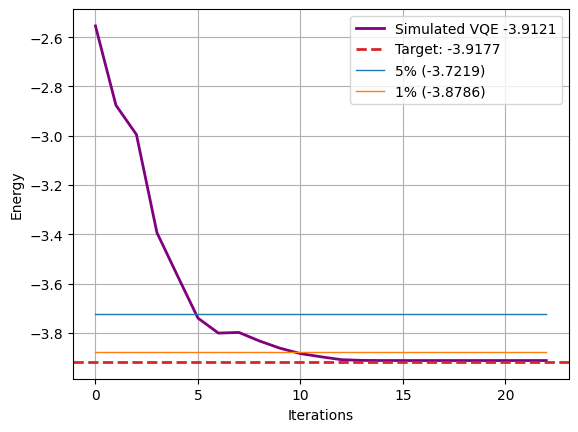

In [71]:
result, values = custom_vqe(estimator, 
                            ansatz_opt, 
                            optimizer, 
                            new_qubit_op,  
                            exact_energy,
                            execution_type,
                            multiplier = None)

In [72]:
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 23,
    'eigenvalue': -3.9121410164594743,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f34723e2640>,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): -3.503518549020355e-06,
                              ParameterVectorElement(θ[5]): 3.141594693342342,
                              ParameterVectorElement(θ[2]): -1.569949665540371,
                              ParameterVectorElement(θ[7]): 1.5715072745610208,
                              ParameterVectorElement(θ[8]): 1.5707993340706794,
                              ParameterVectorElement(θ[9]): 1.5319179133163578,
                              ParameterVectorElement(θ[3]): 1.5707963891619403,
                              ParameterVectorElement(θ[6]): -0.5694539585519441,
                              ParameterVectorElement(θ[4]): 4.712380218145988,
                              ParameterVectorElement(θ[1]): -0.56945409566

In [73]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(exact_energy, result.eigenvalue)

print(f'Expected ground state energy: {exact_energy:.12f}')
print(f'Computed ground state energy: {result.eigenvalue:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -3.917749148316
Computed ground state energy: -3.912141016459
Relative error: 0.001431467826


### Results

We used the `L_BFGS_B` optimizer for maximum 30 iterations. The `computed part energy` is -3.917749148316 while the `ActiveSpaceTransformer extracted energy` is -15.031573995535. The VQE only have to reach to the `computed part energy`. The ideal simulation reaches the desired energy in 30 iterations. A Hartree-Fock initial state $|10100>$ was used with a single layer of Hardware-efficient ansatz. The relative error is within $10^{-2}$ Hartree.

## Methodology

We will now increase the layers of the hardware-efficient ansatz. The paper formualates that for a given convergence criterion , as the number of layers of the hardware-efficient ansatz increases, it is expected that the increase in parametric expression and entangling power would allow for a better approximation of the ground state energy $E_0$ up to a certain minimum circuit layer depth $L_{min}$. 

We increase the layers from 1 to 6 and record the observations

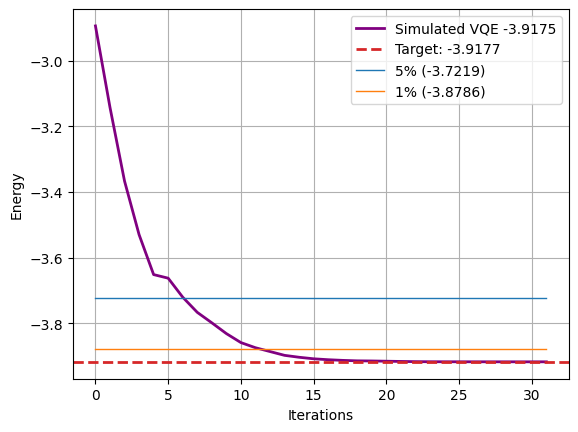

In [74]:
computed_results = [result]

for reps in [2,3,4,5,6]:
    ansatz = get_ansatz(ansatz_type, reps, problem_reduced, converter)
    ansatz_opt, new_qubit_op = device_mapping(ansatz, noisy_sim, qubit_op)

    result, values = custom_vqe(estimator, 
                                ansatz_opt, 
                                optimizer, 
                                new_qubit_op,  
                                exact_energy,
                                execution_type,
                                multiplier = None)
    computed_results.append(result)

### Results

Increasing the number of layers resulted in a decrease in the relative error. The relative error $7.3 \times 10^{-5}$ being the lowest at $L = 6$. With $L = 5$, we are within $10^{-3}$ relative error. Although, increasing the layers reduces the relative error, the optimizer time and the circuit depth increases drastically. 

For further analysis, we stick with the $L = 5$ layer circuit.

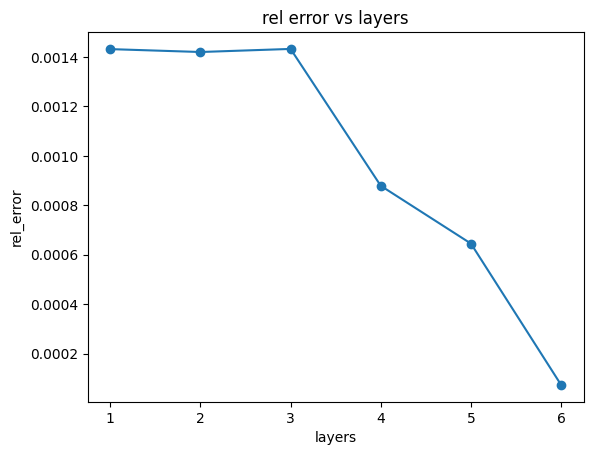

In [83]:
layers = [1,2,3,4,5,6]
rel_errors = [rel_err(exact_energy, res.eigenvalue) for res in computed_results]
plt.plot(layers, rel_errors, marker='o')
plt.xlabel('layers')
plt.ylabel('rel_error')
plt.title('rel error vs layers');

In [84]:
rel_errors

[0.001431467826139564,
 0.0014197870767407108,
 0.0014322566410513284,
 0.0008789056414224993,
 0.0006452154653953008,
 7.380152813348084e-05]

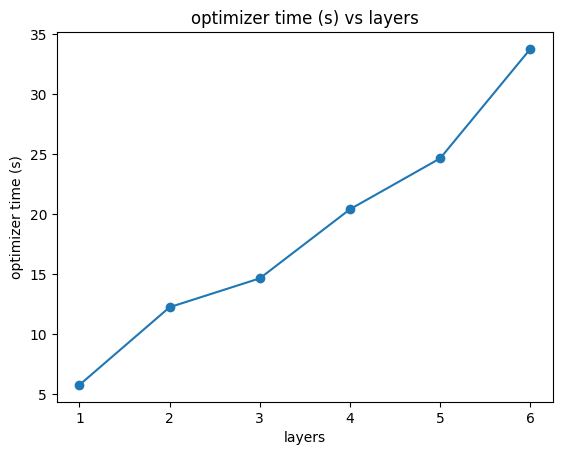

In [85]:
optimizer_times = [res.optimizer_time for res in computed_results]
plt.plot(layers, optimizer_times, marker='o')
plt.xlabel('layers')
plt.ylabel('optimizer time (s)')
plt.title('optimizer time (s) vs layers');

In [86]:
optimizer_times

[5.763438940048218,
 12.244982719421387,
 14.649802446365356,
 20.40982961654663,
 24.656119346618652,
 33.77852773666382]

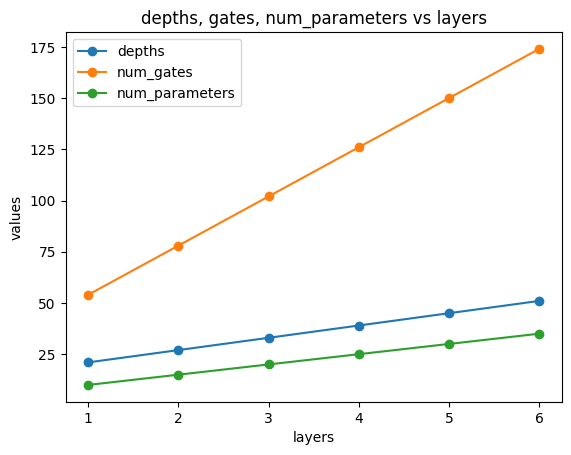

In [99]:
depths = [res.optimal_circuit.depth() for res in computed_results]
gates = [sum(res.optimal_circuit.count_ops().values()) for res in computed_results]
num_parameters = [res.optimal_circuit.num_parameters for res in computed_results]
plt.plot(layers, depths, marker='o')
plt.plot(layers, gates, marker='o')
plt.plot(layers, num_parameters, marker='o')
plt.xlabel('layers')
plt.ylabel('values')
plt.legend(['depths', 'num_gates', 'num_parameters'])
plt.title('depths, gates, num_parameters vs layers');

In [100]:
print(depths)
print(gates)
print(num_parameters)

[21, 27, 33, 39, 45, 51]
[54, 78, 102, 126, 150, 174]
[10, 15, 20, 25, 30, 35]


### Deparameterisation

The paper suggests that in some situations, the Hamiltonian is sufficiently sparse that producing a global minimum with an exact energy does not need full parametrization of all $R_y$ gates in a ansatz with depth $L_{min}$ (or greater). Thus, a heuristic deparameterization approach can be used to further minimise the number of parameter.
The easiest implementation is the one that is described below. 

A parametrized $R_y$ gate is initially chosen and frozen by giving it a set rotation value. The preferred rotation amplitude is zero, however other standardised values, such as $± \pi/2$ or $±\pi$, can also be utilised. The former option is preferred for a number of reasons, including 

- the ability to transform the $R_y$ gate into a virtual identity gate that does not require actual implementation, which eliminates any related quantum gate noise.
- The computational cost of improving the parameter linked to that gate is likewise reduced in terms of software. - Last but not least, we can build quantum circuits with more degrees of freedom for circuit translation by searching for as many virtual identity gates as possible. This may enable more effective mapping of the quantum circuit onto real quantum hardware and hence reduce its effective depth.

In [266]:
l5_result = computed_results[4]
l5_result.optimal_circuit.draw(fold = 300)

global phase: π
                                                                                                                                                                                                                                                                                                       »
ancilla_0 -> 0 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
               ┌───┐   ┌─────────┐   ┌────┐┌──────────────┐┌────┐┌────────┐     ┌────┐┌──────────────┐┌────┐┌────────┐     ┌───┐          ┌────┐┌──────────────┐     ┌────┐        ┌────────┐     ┌───┐                        ┌────┐     ┌───────────────┐      ┌────┐         ┌────────┐     ┌───┐   »
      q_0 -> 1 ┤ X ├───┤ Rz(0.0) ├───┤ √X ├┤ Rz(θ[0] + π) ├┤ √X ├┤ Rz(3π) ├──■──┤ √X ├┤ Rz(θ[5] + π) ├┤ √X ├┤ Rz(3π) ├──■──┤ X ├──■────■──┤ √X ├┤ Rz(θ[6] + π) ├─────┤ √X ├────────┤ Rz(3π) ├─────┤ X ├───────────────■────────┤ √X ├─────┤ Rz(θ[11] + π) ├──────┤ √X ├─────────┤ Rz(3π) ├─────┤ X ├───»
               ├───┴┐┌─┴─────────┴──┐├────┤└──┬────────┬──┘└────┘└────────┘┌─┴─┐└────┘└──────────────┘└────┘└────────┘┌─┴─┐└─┬─┘┌─┴─┐  │  └────┘└──────────────┘     └────┘        └────────┘     └─┬─┘     ┌────┐    │  ┌─────┴────┴────┐└─────┬────┬────┘    ┌─┴────┴─┐       └────────┘     └─┬─┘   »
      q_1 -> 2 ┤ √X ├┤ Rz(θ[1] + π) ├┤ √X ├───┤ Rz(3π) ├───────────────────┤ X ├──────────────────────────────────────┤ X ├──■──┤ X ├──┼────────────────────────────────────────────────────────────■───────┤ √X ├────┼──┤ Rz(θ[10] + π) ├──────┤ √X ├─────────┤ Rz(3π) ├────────────────────────■─────»
               ├───┬┘└─┬─────────┬──┘├────┤┌──┴────────┴──┐┌────┐┌────────┐└───┘                                      └───┘     └───┘┌─┴─┐           ┌────┐     ┌──────────────┐     ┌────┐     ┌────────┐  └────┘  ┌─┴─┐└───────────────┘      ├────┤     ┌───┴────────┴──┐      ┌────┐     ┌────────┐»
      q_2 -> 3 ┤ X ├───┤ Rz(0.0) ├───┤ √X ├┤ Rz(θ[2] + π) ├┤ √X ├┤ Rz(3π) ├──────────────────────────────────────────────────────────┤ X ├──■────────┤ √X ├─────┤ Rz(θ[7] + π) ├─────┤ √X ├─────┤ Rz(3π) ├──────────┤ X ├────────■──────────────┤ √X ├─────┤ Rz(θ[12] + π) ├──────┤ √X ├─────┤ Rz(3π) ├»
               ├───┴┐┌─┴─────────┴──┐├────┤└──┬────────┬──┘└────┘└─┬───┬──┘                                                          └───┘  │        ├───┬┘     └────┬────┬────┘┌────┴────┴────┐└─┬────┬─┘┌────────┐└───┘        │              ├───┬┘     └─────┬────┬────┘┌─────┴────┴────┐└─┬────┬─┘»
      q_3 -> 4 ┤ √X ├┤ Rz(θ[3] + π) ├┤ √X ├───┤ Rz(3π) ├─────■─────┤ X ├─────■──────────────────────────────────────────────────────────────┼────────┤ X ├───────────┤ √X ├─────┤ Rz(θ[9] + π) ├──┤ √X ├──┤ Rz(3π) ├─────────────┼──────────────┤ X ├────────────┤ √X ├─────┤ Rz(θ[14] + π) ├──┤ √X ├──»
               ├────┤├──────────────┤├────┤   ├────────┤   ┌─┴─┐   └─┬─┘   ┌─┴─┐                                                          ┌─┴─┐      └─┬─┘           ├────┤     ├──────────────┤  ├────┤  ├────────┤           ┌─┴─┐            └─┬─┘            ├────┤     ├───────────────┤  ├────┤  »
      q_4 -> 5 ┤ √X ├┤ Rz(θ[4] + π) ├┤ √X ├───┤ Rz(3π) ├───┤ X ├─────■─────┤ X ├──────────────────────────────────────────────────────────┤ X ├────────■─────────────┤ √X ├─────┤ Rz(θ[8] + π) ├──┤ √X ├──┤ Rz(3π) ├───────────┤ X ├──────────────■──────────────┤ √X ├─────┤ Rz(θ[13] + π) ├──┤ √X ├──»
               └────┘└──────────────┘└────┘   └────────┘   └───┘           └───┘                                                          └───┘                      └────┘     └──────────────┘  └────┘  └────────┘           └───┘                             └────┘     └───────────────┘  └────┘  »
ancilla_1 -> 6 ────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [267]:
l5_result.optimal_parameters

{ParameterVectorElement(θ[0]): 0.397914044135567,
 ParameterVectorElement(θ[1]): 0.8250652879035364,
 ParameterVectorElement(θ[2]): 0.23723938572768918,
 ParameterVectorElement(θ[3]): 0.2513106929174353,
 ParameterVectorElement(θ[4]): 1.6366565949534575,
 ParameterVectorElement(θ[5]): 0.733719619022135,
 ParameterVectorElement(θ[6]): 0.6153890345026768,
 ParameterVectorElement(θ[7]): 0.492613881863658,
 ParameterVectorElement(θ[8]): 1.1855720357685295,
 ParameterVectorElement(θ[9]): -0.018701476807503645,
 ParameterVectorElement(θ[10]): -0.7058508929041959,
 ParameterVectorElement(θ[11]): 0.7054056677763221,
 ParameterVectorElement(θ[12]): 1.5798814615258383,
 ParameterVectorElement(θ[13]): -0.39596076520169987,
 ParameterVectorElement(θ[14]): 0.011691386035588591,
 ParameterVectorElement(θ[15]): 0.400985223430477,
 ParameterVectorElement(θ[16]): -0.07757744690571132,
 ParameterVectorElement(θ[17]): 1.5324912416601388,
 ParameterVectorElement(θ[18]): -0.11545780127951417,
 ParameterVec

#### Deparameterise circuit

A helper function to deparameterise the given circuit. It accepts the following arguments

- `circuit` is the parameterised quantum circuit
- `optimial_parameters` is a dict with parameter as keys with their values
- `freeze_indices` is the indices of the parameter which the user wants to freeze
- `freeze_value` is the value which we want to put for the freezed parameters.

The function returns a circuit with the frozen parameters.

In [42]:
def deparameterise(circuit, optimal_parameters, freeze_indices, freeze_value):
    partial_params = {}
    for (i, j) in optimal_parameters.items():
        if i.index in freeze_indices:
            partial_params[i] = freeze_value
    
    for i, j in partial_params.items():
        print(i, j)
    
    return circuit.assign_parameters(partial_params)

## Procedure

For the $L = 5$ circuit, we iteratively freeze the parameters. Moreover, we observed that several parameters in the global minima tended to have the standardised values of  $0.0$, $± \pi/2$ or $±\pi$. 4. We specifically froze Parameter 12, 17, and 23 while keeping all other parameters active for the first run of the deparameterization method. The technique was then repeated until the maximum decrease of active parameters from 30 to 11 was achieved. With 11 parameters, we did not find the standardised values and hence we stop.

#### Run 1

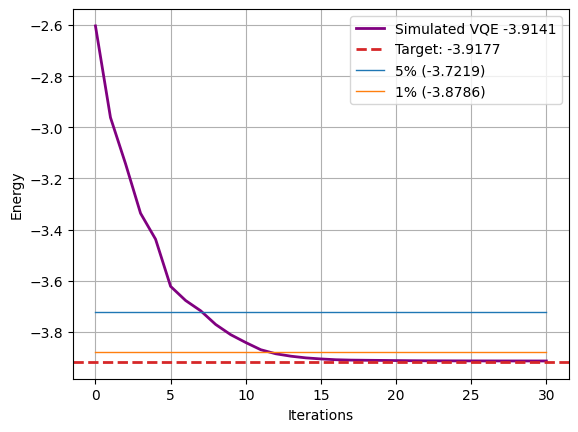

In [270]:
deparameterise_results = []
tqc = deparameterise(l5_result.optimal_circuit,
               l5_result.optimal_parameters,
               [12, 17, 23], np.pi/2)
l5_result, values = custom_vqe(estimator, 
                            tqc, 
                            optimizer, 
                            new_qubit_op,  
                            exact_energy,
                            execution_type,
                            multiplier =None )
deparameterise_results.append(l5_result)

In [271]:
l5_result.optimal_parameters

{ParameterVectorElement(θ[0]): -0.03304513799958174,
 ParameterVectorElement(θ[1]): -0.026662610171048793,
 ParameterVectorElement(θ[2]): -0.0033450321001212116,
 ParameterVectorElement(θ[3]): 0.46173234710376687,
 ParameterVectorElement(θ[4]): 0.392163338074502,
 ParameterVectorElement(θ[5]): 1.1266201289952118,
 ParameterVectorElement(θ[6]): -1.2785701469379196,
 ParameterVectorElement(θ[7]): 0.7440817601933649,
 ParameterVectorElement(θ[8]): 0.9594630795717292,
 ParameterVectorElement(θ[9]): 0.32824268203951346,
 ParameterVectorElement(θ[10]): 1.990969284362832,
 ParameterVectorElement(θ[11]): 1.6516858374961771,
 ParameterVectorElement(θ[13]): 0.7823499648003317,
 ParameterVectorElement(θ[14]): 0.512650079040143,
 ParameterVectorElement(θ[15]): 0.26240604470162227,
 ParameterVectorElement(θ[16]): 0.7951111881048952,
 ParameterVectorElement(θ[18]): -0.45830553329302637,
 ParameterVectorElement(θ[19]): 0.6346466422361813,
 ParameterVectorElement(θ[20]): -0.09148818031162212,
 Paramet

#### Run 2

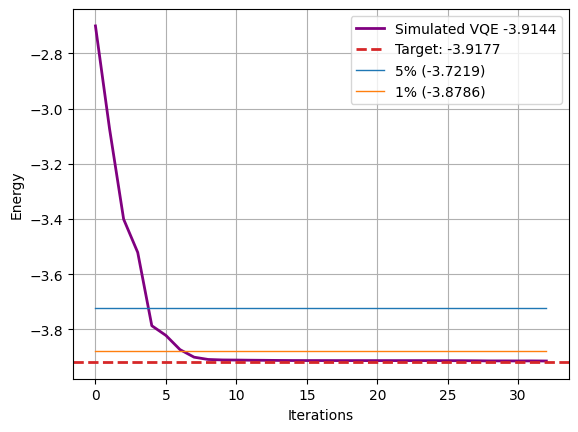

In [272]:
tqc = deparameterise(l5_result.optimal_circuit,
               l5_result.optimal_parameters,
               [0,1,2,20,21,25,26], 0.0)
l5_result, values = custom_vqe(estimator, 
                            tqc, 
                            optimizer, 
                            new_qubit_op,  
                            exact_energy,
                            execution_type,
                            multiplier = None)
deparameterise_results.append(l5_result)

In [273]:
l5_result.optimal_parameters

{ParameterVectorElement(θ[3]): 0.3428219020283039,
 ParameterVectorElement(θ[4]): 1.1553943192355651,
 ParameterVectorElement(θ[5]): 1.5883173548862595,
 ParameterVectorElement(θ[6]): 0.07300637078969935,
 ParameterVectorElement(θ[7]): 1.5325693179995363,
 ParameterVectorElement(θ[8]): 1.2548448753011692,
 ParameterVectorElement(θ[9]): 0.6717283174197278,
 ParameterVectorElement(θ[10]): 1.8262477603349472,
 ParameterVectorElement(θ[11]): 1.7279070399617955,
 ParameterVectorElement(θ[13]): 1.5472047208273216,
 ParameterVectorElement(θ[14]): 1.7910333507577718,
 ParameterVectorElement(θ[15]): 1.6372044444469815,
 ParameterVectorElement(θ[16]): 0.04330851404039325,
 ParameterVectorElement(θ[18]): 1.1752159798246,
 ParameterVectorElement(θ[19]): -1.355124489572105,
 ParameterVectorElement(θ[22]): 1.5981082702844145,
 ParameterVectorElement(θ[24]): -0.045120185376345844,
 ParameterVectorElement(θ[27]): -0.12414844911901923,
 ParameterVectorElement(θ[28]): -0.12788522779797906,
 ParameterVec

#### Run 3

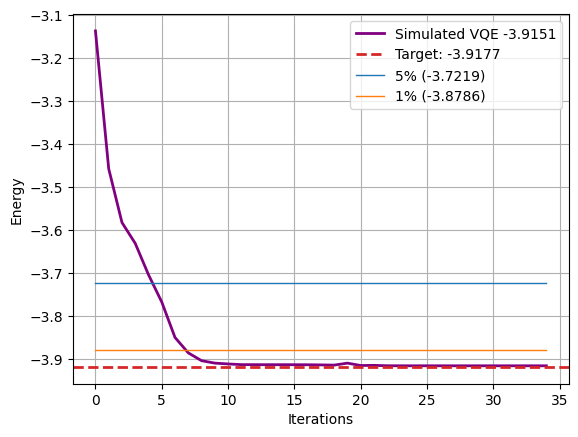

In [274]:
tqc = deparameterise(l5_result.optimal_circuit,
               l5_result.optimal_parameters,
               [5,7,13,22,29], np.pi/2)
l5_result, values = custom_vqe(estimator, 
                            tqc, 
                            optimizer, 
                            new_qubit_op,  
                            exact_energy,
                            execution_type,
                            multiplier = None)
deparameterise_results.append(l5_result)

In [275]:
l5_result.optimal_parameters

{ParameterVectorElement(θ[3]): -0.013214348521797006,
 ParameterVectorElement(θ[4]): -0.08581296631359601,
 ParameterVectorElement(θ[6]): -4.978594068458372e-06,
 ParameterVectorElement(θ[8]): 1.5890671950865056,
 ParameterVectorElement(θ[9]): -1.4909236872261493,
 ParameterVectorElement(θ[10]): 0.06714147821594833,
 ParameterVectorElement(θ[11]): -0.055024155208389096,
 ParameterVectorElement(θ[14]): -1.5580831974492388,
 ParameterVectorElement(θ[15]): 1.5748224644689743,
 ParameterVectorElement(θ[16]): 0.00068488046409408,
 ParameterVectorElement(θ[18]): -0.5661055415888475,
 ParameterVectorElement(θ[19]): 1.5577651984783942,
 ParameterVectorElement(θ[24]): -0.04034212117057228,
 ParameterVectorElement(θ[27]): 1.0101916051379547,
 ParameterVectorElement(θ[28]): -0.024040736819985486}

#### Run 4

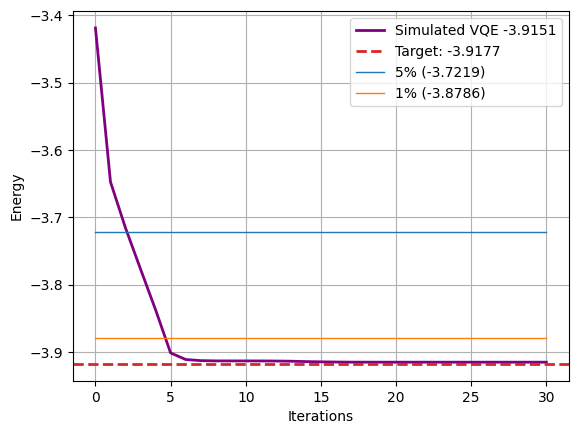

In [276]:
tqc = deparameterise(l5_result.optimal_circuit,
               l5_result.optimal_parameters,
               [8,15,19], np.pi/2)
l5_result, values = custom_vqe(estimator, 
                            tqc, 
                            optimizer, 
                            new_qubit_op,  
                            exact_energy,
                            execution_type,
                            multiplier = None)
deparameterise_results.append(l5_result)

In [277]:
l5_result.optimal_parameters

{ParameterVectorElement(θ[3]): 0.000420910049327059,
 ParameterVectorElement(θ[4]): 0.8857307521330984,
 ParameterVectorElement(θ[6]): 3.072217157498276e-05,
 ParameterVectorElement(θ[9]): 0.6833524290644309,
 ParameterVectorElement(θ[10]): 0.5566064984992161,
 ParameterVectorElement(θ[11]): 0.6782435999198911,
 ParameterVectorElement(θ[14]): -1.5707459281334364,
 ParameterVectorElement(θ[16]): 4.0535650883680575e-05,
 ParameterVectorElement(θ[18]): 0.6288116687902469,
 ParameterVectorElement(θ[24]): -0.03884351924543262,
 ParameterVectorElement(θ[27]): -0.9401501319627521,
 ParameterVectorElement(θ[28]): 0.00048481924940992955}

#### Run 5

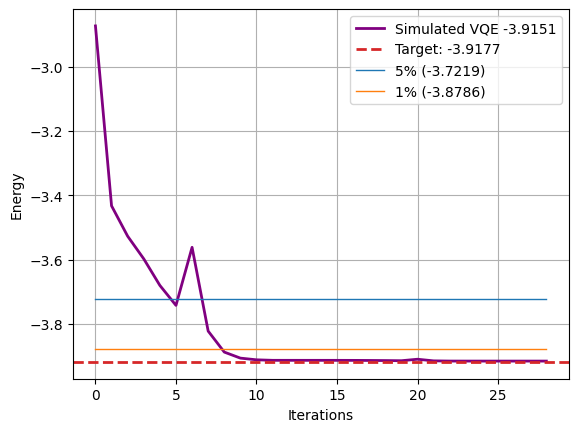

In [278]:
tqc = deparameterise(l5_result.optimal_circuit,
               l5_result.optimal_parameters,
               [0,28], 0.0)
l5_result, values = custom_vqe(estimator, 
                            tqc, 
                            optimizer, 
                            new_qubit_op,  
                            exact_energy,
                            execution_type,
                            multiplier = None)
deparameterise_results.append(l5_result)

In [279]:
l5_result.optimal_parameters

{ParameterVectorElement(θ[3]): -8.703243422474598e-07,
 ParameterVectorElement(θ[4]): 0.71740111116123,
 ParameterVectorElement(θ[6]): 1.1764541898451023e-05,
 ParameterVectorElement(θ[9]): 0.8536142645240843,
 ParameterVectorElement(θ[10]): 0.24575657983278992,
 ParameterVectorElement(θ[11]): 0.36733013619233845,
 ParameterVectorElement(θ[14]): -1.5707783853307966,
 ParameterVectorElement(θ[16]): -1.6114740181746609e-06,
 ParameterVectorElement(θ[18]): 1.1714754370205425,
 ParameterVectorElement(θ[24]): -0.0388441443206627,
 ParameterVectorElement(θ[27]): -0.39954498468171284}

## Results of Deparameterisation

Initially, the relative error for $L=5$ circuit was `0.00064` and the runtime was `24.6561` seconds. After deparameterisation, the relative error increase to `0.00066`. A `2.82 percent` increase to be precise. However, the optimizer runtime reduces by `60.8 percent`. 

The time required for optimization is significantly impacted by the deparameterization procedure's significant simplification of the $L = 5$ circuit ansatz energy landscape and the decrease in computing cost brought on by optimising fewer parameters.

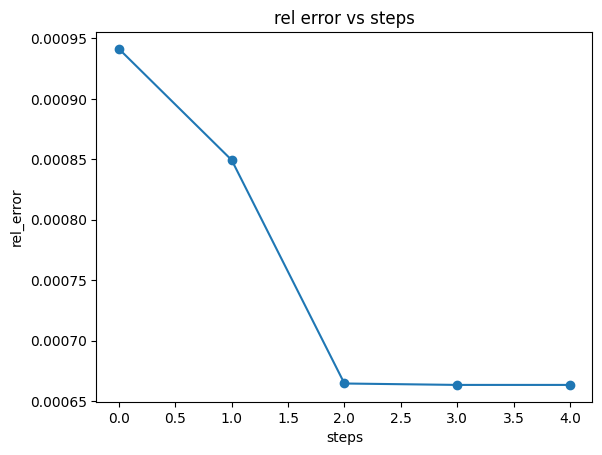

In [281]:
steps = list(range(len(deparameterise_results)))
rel_errors = [rel_err(exact_energy, res.eigenvalue) for res in deparameterise_results]
plt.plot(steps, rel_errors, marker='o')
plt.xlabel('steps')
plt.ylabel('rel_error')
plt.title('rel error vs steps');

In [282]:
rel_errors

[0.000941262997849974,
 0.0008493479759547075,
 0.0006646202577521038,
 0.0006634487043998169,
 0.0006634438841662399]

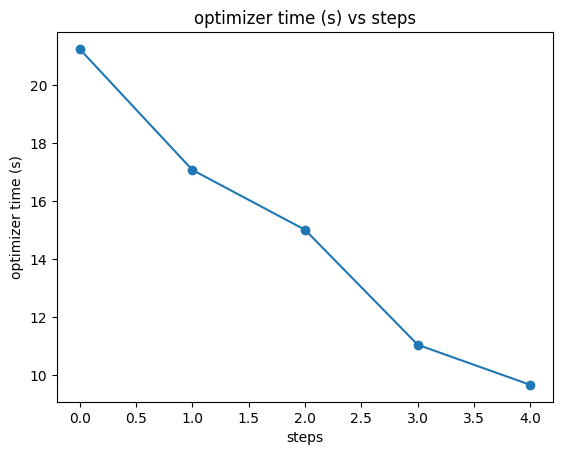

In [283]:
optimizer_times = [res.optimizer_time for res in deparameterise_results]
plt.plot(steps, optimizer_times, marker='o')
plt.xlabel('steps')
plt.ylabel('optimizer time (s)')
plt.title('optimizer time (s) vs steps');

In [284]:
optimizer_times

[21.247840642929077,
 17.078510284423828,
 15.011550903320312,
 11.04953384399414,
 9.665789604187012]

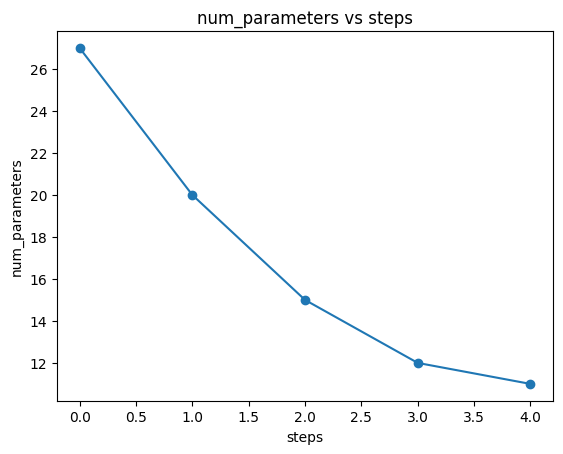

In [285]:
num_parameters = [res.optimal_circuit.num_parameters for res in deparameterise_results]
plt.plot(steps, num_parameters, marker='o')
plt.xlabel('steps')
plt.ylabel('num_parameters')
plt.title('num_parameters vs steps');

In [286]:
print(num_parameters)

[27, 20, 15, 12, 11]


## Noisy Sim

We test the reduced parameter circuit with the noisy sim as backend. We use Qiskit's [Backend Estimator Primitive](https://qiskit.org/documentation/stubs/qiskit.primitives.BackendEstimator.html#qiskit.primitives.BackendEstimator) for this purpose. We try different error mitigation schemes which is controlled by the parameter `resilience level`:

- `0`: No mitigation
- `1`: Twirled Readout Error eXtinction ([TREX](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/how_to/error-mitigation.html#trex))
- `2`: Zero Noise Extrapolation ([ZNE](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/how_to/error-mitigation.html#zne))
- `3`: Probabilistic Error Cancellation ([PEC](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/how_to/error-mitigation.html#pec))

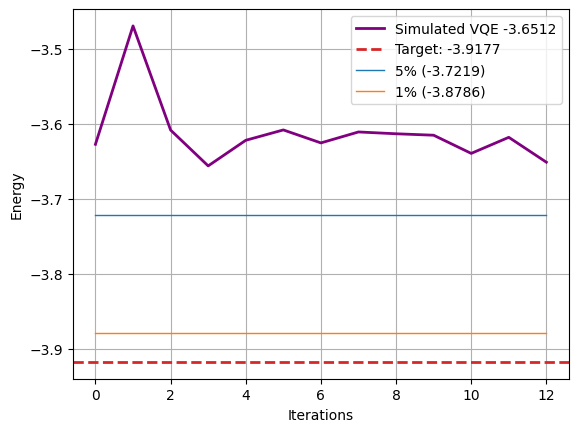

In [311]:
ansatz_opt = deparameterise_results[-1].optimal_circuit
initial_point = deparameterise_results[-1].optimal_point

noisy_sim_results = []
optimizer = get_optimizer(optimizer_type, max_iter = 30 , a = 0.05, c = 0.05)

for resilience_level in range(3):
    print(resilience_level)
    noisy_estimator = BackendEstimator(backend = noisy_sim, options = {
        'resilience_level': resilience_level
    })

    result_noisy, values = custom_vqe(noisy_estimator, 
                                ansatz_opt, 
                                optimizer, 
                                new_qubit_op,  
                                exact_energy,
                                execution_type,
                                multiplier = None,
                                init_point = initial_point)

    noisy_sim_results.append(result_noisy)

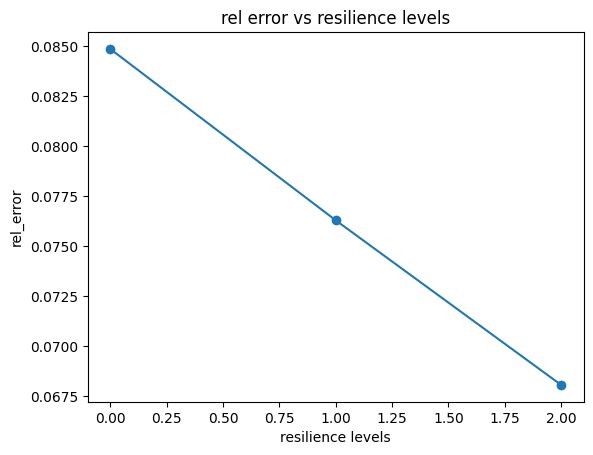

In [313]:
levels = list(range(len(noisy_sim_results)))
rel_errors = [rel_err(exact_energy, res.eigenvalue) for res in noisy_sim_results]
plt.plot(levels, rel_errors, marker='o')
plt.xlabel('resilience levels')
plt.ylabel('rel_error')
plt.title('rel error vs resilience levels');

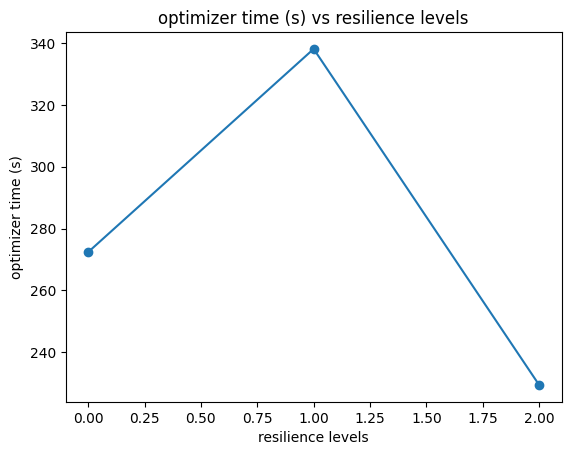

In [342]:
optimizer_times = [res.optimizer_time for res in noisy_sim_results]
plt.plot(levels, optimizer_times, marker='o')
plt.xlabel('resilience levels')
plt.ylabel('optimizer time (s)')
plt.title('optimizer time (s) vs resilience levels');

In [314]:
rel_errors

[0.08484675077799134, 0.07627896041281863, 0.06804617076318921]

## Results with Noisy Sim

The relative error decreases as we increase the resilience level. We did not report the result with resilience level = 3 as it was not time effective. The least relative error is `0.0680` with `level = 2` which is within `6.7 percent` the actual value. A more interesting result is that the runtime with `level = 2` is the least of all the other levels. We can perform further experiments on this topic.

The results are not within 1 percent due to high noise of the device and large number of 2 qubit gates (20 CNOT gates).

## BraketLocal Backend

We also used BraketLocalBackend provided by the [qiskit-braket-provider](https://github.com/qiskit-community/qiskit-braket-provider) to test our circuit. The simulator is ideal. The BraketLocalBackend asks for contiguous qubits and since the Hamiltonian uses only 5 qubits, we need to remove the idle qubits. For this we create and use a helper function `remove_idle_qwires`.

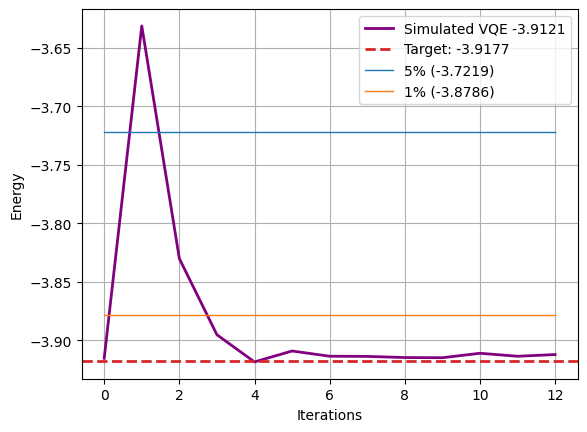

In [339]:
optimizer = get_optimizer(optimizer_type, max_iter = 5 , a = 0.05, c = 0.05)
noisy_estimator = BackendEstimator(backend = BraketLocalBackend())
_ansatz = remove_idle_qwires(ansatz_opt)

result_braket, values = custom_vqe(noisy_estimator, 
                            _ansatz, 
                            optimizer, 
                            qubit_op,  
                            exact_energy,
                            execution_type,
                            multiplier = None,
                            init_point = initial_point)

In [341]:
print(result_braket)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 13,
    'eigenvalue': -3.912076755052964,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f3472111340>,
    'optimal_parameters': {   ParameterVectorElement(θ[14]): -1.543728819284337,
                              ParameterVectorElement(θ[27]): -0.3878501228149755,
                              ParameterVectorElement(θ[16]): 0.012832258051985079,
                              ParameterVectorElement(θ[18]): 1.1389206763838813,
                              ParameterVectorElement(θ[9]): 0.8705431150647851,
                              ParameterVectorElement(θ[24]): -0.0700583299906817,
                              ParameterVectorElement(θ[10]): 0.215272063269717,
                              ParameterVectorElement(θ[11]): 0.34549240175582985,
                              ParameterVectorElement(θ[6]): 0.02189797906861507,
                              ParameterVectorElement(θ[4]): 0.7246

In [340]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(exact_energy, result_braket.eigenvalue)

print(f'Expected ground state energy: {exact_energy:.12f}')
print(f'Computed ground state energy: {result_braket.eigenvalue:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -3.917749148316
Computed ground state energy: -3.912076755053
Relative error: 0.001447870460


## Results with BraketLocalBackend

The results, as expected are close to the exact energy. The relative error being `0.00144`, within $10^{-2}$ Hartree. The runtime was unexpectedly high `948` seconds ~ 16 minutes. 

The qiskit-braket-provider is still in an early phase and requires more development on the side of simulators.

## Carbon capture on MOFs with quantum chemistry

We seeks to learn how quantum computers might help to advance the materials used in carbon dioxide direct air capture (DAC) of $CO_2$. By estimating the minimum of the PES of atmospheric gas molecules like $CO_2$, $H_2O$ etc. close to the MOFs' preferential binding sites, it will be specifically assessed how metal organic frameworks (MOFs) may be accommodated in DAC.

## Direct Air Capture

Below image [1] describes the process of direct air capture in a nutshell.

![DAC](images/DAC.jpg)

The technology's energy requirement is one of the biggest obstacles to overcome. One is that the atmosphere of the earth contains extremely diluted CO2. As a result, a lot of air must pass through the filter in order to effectively capture $CO_2$. The ratio of the capture time to the release time, which occurs throughout the two phases of $CO_2$ collection and release, directly relates to the filter's capacity. As a result, filters with a high capacity for $CO_2$ adsorption are generally desired.

We can use Metal-Organic Frameworks (MOFs) as filters for $CO_2$. To reduce the problem's complexity we focus on only the active binding site of the MOF i.e. the metal iion Our objective is to use VQE for finding the minimum of the PES of a $CO_2$ with 2 metal ions $Mn(II)$ and $Cu(I)$ (separately). We run the algorithm on simulators and use the deparameterisation technique to make it suitable for running on noisy simulators and real hardware.

We consider only one metal ion at a time with fixed orientation and compute the minimum of the PES for a fixed distance between $CO_2$ and the metal ion. Below image shows that the molecules ($CO_2$ with $Mn(II)$ and $Cu(I)$ ) like on a single axis.

![CO2_ion](images/CO2_ion.png)

## Reference energy

For finding the reference energy of the system of molecules we use [Quantistry](https://quantistry.com/en). We get the Hartree-fock energy, Second-order Møller–Plesset perturbation theory (MP2 energy) and Coupled Cluster Singles and Doubles (CCSD energy) as reference.

For our analysis, we take the minimum CCSD energy and use the corresponding root mean square deviation (in angstorm). From the plots and the dataFrame, we chose the `0.985944 angstorm` as the distance between the $Mn(II)$ metal ion and $CO_2$ oxygen atom. The corresponding CCSD energy is `-36397.363860 eV`. 

In [13]:
df = pd.read_csv('ccsd_reference_potential_energy_curve.csv')
df

,step,root mean square deviation [a0],HF energy [eV],MP2 energy [eV],CCSD energy [eV]
0,0,0.000000,-36373.450786,-36393.936221,-36394.033950
1,1,0.328648,-36376.166159,-36396.302106,-36396.427922
2,2,0.657296,-36377.181166,-36397.119672,-36397.256820
3,3,0.985944,-36377.410263,-36397.222117,-36397.363860
4,4,1.314592,-36377.300044,-36397.022932,-36397.165861
5,5,1.643240,-36377.063640,-36396.720203,-36396.862701
6,6,1.971888,-36376.799744,-36396.405796,-36396.547289
7,7,2.300536,-36376.550850,-36396.118740,-36396.259213
8,8,2.629184,-36376.332177,-36395.871520,-36396.011193
9,9,2.957832,-36376.146448,-36395.664061,-36395.803210


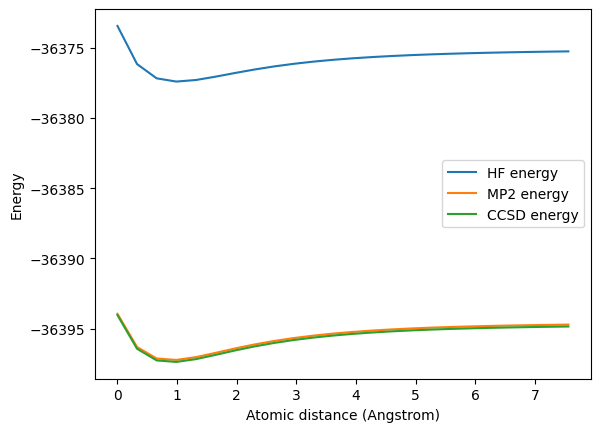

In [14]:
atomic_distance = df[df.keys()[1]]
hf_energy = df[df.keys()[2]]
mp2_energy = df[df.keys()[3]]
ccsd_energy = df[df.keys()[4]]

plt.plot(atomic_distance, hf_energy, label="HF energy")
plt.plot(atomic_distance, mp2_energy, label="MP2 energy")
plt.plot(atomic_distance, ccsd_energy, label="CCSD energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

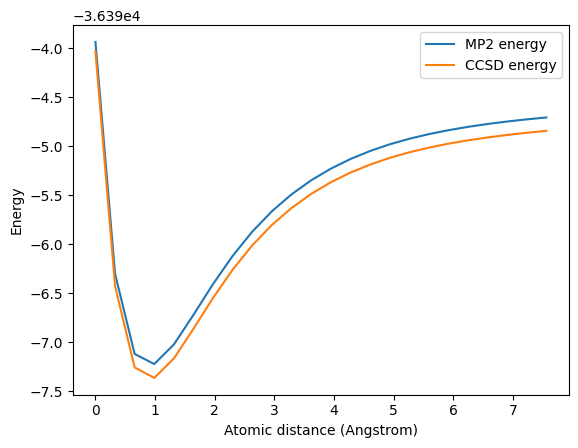

In [15]:
plt.plot(atomic_distance, mp2_energy, label="MP2 energy")
plt.plot(atomic_distance, ccsd_energy, label="CCSD energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

## Setup CO2 @ Mn (II) system

The results obtained from quantistry are with the `ccpvdz` basis, so we use it here. We consider all the electrons in system and try to find the number of spatial orbitals with which we can efficiently calculate the ground state energy.

We iterate over the `num_spatial_orbitals` from 3 till 10. Beyond 10, it was not feasible to proceed with the amount of time it takes to calculate the Hamiltonian. 

In [12]:
co2 =  [["C", np.array([17.0000, 10.0000, 0.0000 ])],
        ["O", np.array([18.0221, 10.5679, 0.0000 ])],
        ["O", np.array([15.9779, 9.4321, 0.0000  ])]] 

# Normalize CO2
d_co1 = np.linalg.norm(co2[0][1] - co2[1][1])
d_co2 = np.linalg.norm(co2[0][1] - co2[2][1])

spin = 5*0.5
charge = 2
basis = "ccpvdz"
mapper_type = 'ParityMapper'
ev = 27.2114
min_dist = 0.985944

CO2 = f"C 0.0 0.0 0.0 ; O -{d_co1} 0.0 0.0 ; O {d_co2} 0.0 0.0"
Mn = f"Mn {d_co2 + min_dist} 0.0 0.0"
geometry = f"{CO2} ; {Mn}"

num_spatial_orbitals = [3,4,5,6,7,8,9,10]

In [19]:
data = {
    'num_spatial_orbitals': [],
    'exact_energies_ev': [],
    'num_hamiltonian_terms': [],
    'num_qubits': [],
    
}
for i in num_spatial_orbitals:
    problem_reduced, converter, qubit_op, res_actual = construct_problem( geometry, 
                                                                      charge, 
                                                                      spin, 
                                                                      basis, 
                                                                      mapper_type,
                                                                      num_spatial_orbitals = i,
                                                                      num_electrons = None, 
                                                                      z2symmetry_reduction='auto')
    
    data['num_spatial_orbitals'].append(i)
    data['exact_energies_ev'].append(res_actual.total_energies[0]*ev)
    data['num_hamiltonian_terms'].append(len(qubit_op))
    data['num_qubits'].append(qubit_op.num_qubits)
    
    print(res_actual)
    print(f"Num spatial orbitals: {i}")
    print(f"Number of Hamiltonian terms: {len(qubit_op)}")
    print(f"Number of qubits :{qubit_op.num_qubits}")
    print(f"Total ground state energy (Ev): {res_actual.total_energies[0]*ev}")
    print('-'*100)
    
    pd.DataFrame(data).to_csv('exact_energies.csv')

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1561.574491530425
  - computed part:      -663.889337946369
  - ActiveSpaceTransformer extracted energy part: -897.685153584056
~ Nuclear repulsion energy (Hartree): 233.938242350371
> Total ground state energy (Hartree): -1327.636249180054
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 6.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [101.81923605  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [96.33119511  0.0  0.0]
    - computed part:      [24.43548558  0.0  0.0]
    - ActiveSpaceTransformer extracted energy part: [71.89570953  0.0  0.0]
  > Dipole moment (a.u.): [5.48804094  0.0  0.0]  Total: 5.48804094
                 (debye): [13.94920737  0.0  0.0]  Total: 13.94920737
 
Num spatial orbitals: 3
Number of Hamiltonian terms: 100
Number of qubits :4
Total ground state energy (Ev): -36126.84103093813
--------------------------------------------------

## Analysis with num_spatial_orbitals

We use [Qiskit's NumPyMinimumEigensolver](https://qiskit.org/documentation/stubs/qiskit.algorithms.minimum_eigensolvers.NumPyMinimumEigensolver.html#qiskit.algorithms.minimum_eigensolvers.NumPyMinimumEigensolver) to find the exact ground state energy of the system while varying the `num_spatial_orbitals`. Increasing the `num_spatial_orbitals` lead to increase the number of qubits needed to simulate the hamiltonian. The interesting part is the ground state energy which remains the same `-36126.84103093809 eV`. Only the absolute values of the `computed energy` and the `ActiveSpaceTransformer extracted energy part` changes. 

The ground state energy as computed by the NumPyMinimumEigensolver is within `0.007432484` relative error. Since the number of hamiltonian terms scales quickly with `num_spatial_orbitals`, we stick to `num_spatial_orbitals = 3` for the analysis.

With 3 spatial orbitals, the goal is to use VQE to reach the `computed part energy = -663.889337946369 Hartree`. Note that Qiskit uses `Hartree` as the unit of energy. We need to multiply the result with `27.2114` to get result in `eV`.

```
* Electronic ground state energy (Hartree): -1561.574491530425
  - computed part:      -663.889337946369
  - ActiveSpaceTransformer extracted energy part: -897.685153584056
~ Nuclear repulsion energy (Hartree): 233.938242350371
> Total ground state energy (Hartree): -1327.636249180054
```

## VQE CO2 @ Mn(||)

With 3 spatial orbitals, we use `SPSA` optimizer for updating the parameters. Only single layer of the Hardware-efficient ansatz is used (which still led to low relative error). Even after `z2 symmetry reduction` the number of hamiltonian terms are `100` and the number of qubits is `4`. The computed Hartree-Fock state is $|1001>$

In [67]:
# configuration
num_spatial_orbitals = 3
execution_type = 'local'
z2symmetry_reduction = 'auto'
optimizer_type = 'SPSA'
ansatz_type = 'TwoLocal'
reps = 1

In [68]:
problem_reduced, converter, qubit_op, res_actual = construct_problem( geometry, 
                                                                      charge, 
                                                                      spin, 
                                                                      basis, 
                                                                      mapper_type,
                                                                      num_spatial_orbitals,
                                                                      num_electrons = None, 
                                                                      z2symmetry_reduction=z2symmetry_reduction)
exact_energy = res_actual.eigenvalues[0]

In [69]:
print(f'Expected ground state energy: {exact_energy:.12f}')

Expected ground state energy: -663.889337946367


In [70]:
len(qubit_op), qubit_op.num_qubits

(100, 4)

In [71]:
ansatz = get_ansatz(ansatz_type, reps, problem_reduced, converter)
ansatz_opt, new_qubit_op = device_mapping(ansatz, noisy_sim, qubit_op)

In [72]:
ansatz.decompose().draw(fold = 200)

┌───────────┐┌──────────┐     ┌──────────┐                        
q_0: ┤ U3(π,0,π) ├┤ Ry(θ[0]) ├──■──┤ Ry(θ[4]) ├────────────────────────
     └┬──────────┤└──────────┘┌─┴─┐└──────────┘┌──────────┐            
q_1: ─┤ Ry(θ[1]) ├────────────┤ X ├─────■──────┤ Ry(θ[5]) ├────────────
      ├──────────┤            └───┘   ┌─┴─┐    └──────────┘┌──────────┐
q_2: ─┤ Ry(θ[2]) ├────────────────────┤ X ├─────────■──────┤ Ry(θ[6]) ├
     ┌┴──────────┤┌──────────┐        └───┘       ┌─┴─┐    ├──────────┤
q_3: ┤ U3(π,0,π) ├┤ Ry(θ[3]) ├────────────────────┤ X ├────┤ Ry(θ[7]) ├
     └───────────┘└──────────┘                    └───┘    └──────────┘

In [73]:
print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
print('depth of the circuit:', ansatz_opt.depth())
print("total number of gates in the circuit:", sum(ansatz_opt.count_ops().values()))

number and type of gates in the cirucit: OrderedDict([('rz', 18), ('sx', 16), ('cx', 6), ('x', 2)])
number of parameters in the circuit: 8
depth of the circuit: 20
total number of gates in the circuit: 42


## Simulation

Picking an initial point is plays a significant role in convergence of the VQE algorithm. For this we created a helper function to find a multiplier for the initial point. We use this for crafting the initial point for the VQE. We run the algorithm for a maximum of 100 iterations.

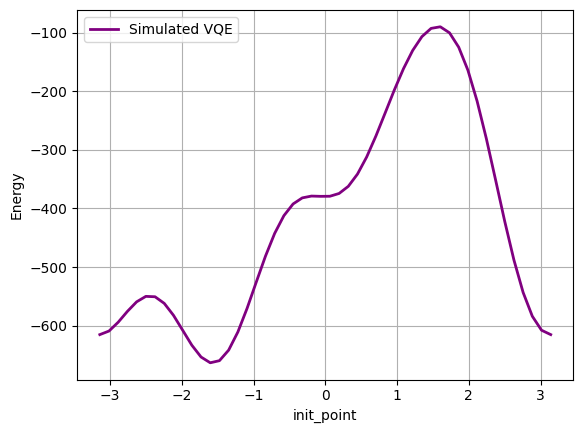

In [75]:
multiplier = init_point_finder(ansatz_opt, optimizer_type, new_qubit_op)

In [76]:
multiplier 

-1.60285339468867

In [77]:
optimizer = get_optimizer(optimizer_type, max_iter =100 , a = 0.01, c = 0.02)

estimator = Estimator(
        options = {
            "method": "density_matrix",
            "coupling_map": coupling_map,
            "seed": seed, 
            "seed_transpiler": seed,
            "optimization_level":0,
        }
    )

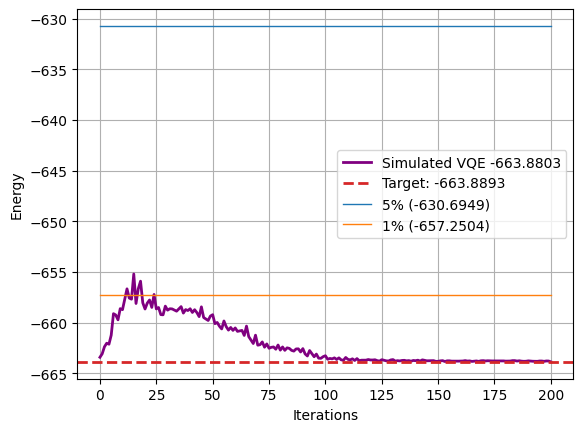

In [78]:
result, values = custom_vqe(estimator, 
                            ansatz_opt, 
                            optimizer, 
                            new_qubit_op,  
                            exact_energy,
                            execution_type,
                            multiplier)

In [79]:
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 200,
    'eigenvalue': -663.8803200366451,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f3d6672c7f0>,
    'optimal_parameters': {   ParameterVectorElement(θ[3]): -1.5709697321952845,
                              ParameterVectorElement(θ[2]): -1.5720707993343777,
                              ParameterVectorElement(θ[7]): -1.5460566077002469,
                              ParameterVectorElement(θ[6]): -1.5713595594476593,
                              ParameterVectorElement(θ[5]): -1.575107513959218,
                              ParameterVectorElement(θ[0]): -0.8516664766564508,
                              ParameterVectorElement(θ[1]): -1.5655119605145231,
                              ParameterVectorElement(θ[4]): -0.8549165052020913},
    'optimal_point': array([-0.85166648, -1.56551196, -1.5720708 , -1.57096973, -0.85491651,
       -1.57510751, -1.57135956, -1.54605661]),
    'opt

In [80]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(exact_energy, result.eigenvalue)

print(f'Expected ground state energy: {exact_energy:.12f}')
print(f'Computed ground state energy: {result.eigenvalue:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -663.889337946367
Computed ground state energy: -663.880320036645
Relative error: 0.000013583453


## Results

The algorithm sucessufully converges to the `computed part energy` in ~30 seconds with a relative error of `0.000013583453` that is within $10^{-4}$ Hartree.

The relative error of `VQE's ground state energy` with the `ground state energy of the NumPyMinimumEigensolver` is calculated as follows:

- Total ground state energy by NumPyMinimumEigensolver (Hartree): -1327.636249180054

- Total ground state energy by VQE (Hartree) = 
    - VQE's computed part energy + ActiveSpaceTransformer extracted energy part + Nuclear repulsion energy
    - = `−1327.62723127 Hartree`
    
The relative error is `0.000006792` which is within $10^{-5}$.

The relative error of `VQE's ground state energy` with the `classical reference solution` is calculated as follows:

- Convert Hartree to eV: −1327.62723127 $\times$ 27.2114 = `-36126.59564098 eV`
- Classical reference solution: `-36397.363860 eV`

The relative error is `0.007439226` which is within $10^{-2}$.

### Deparameterisation

We perfrom deparameterisation of the ansatz as we did previously with $BeH_2$. Observe that most the parameters ( parameters 1,2,3,5 and 6 to be specific) are in the vicinity of $-\pi/2$. We freeze these parameters and now we are left with only 3 parameters to optimize for. The optimization needed on 5 iterations (~ 2 seconds,  a `93.3 percent` decrease in the runtime) with a relative errror of `0.000009399056` (`30 percent` decrease).

The relative error of `VQE's ground state energy` with the `classical reference solution` is `0.007437149` (a `0.0279 percent` decrease).

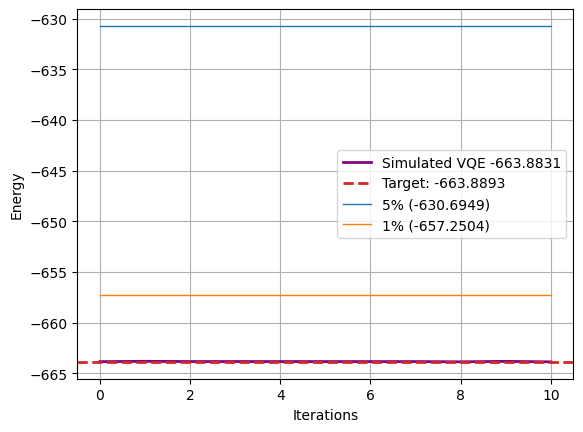

In [81]:
optimizer = get_optimizer(optimizer_type, max_iter = 5 , a = 0.01, c = 0.02)
tqc = deparameterise(result.optimal_circuit,
                     result.optimal_parameters,
                     [1, 2, 3, 5, 6], -np.pi/2)

l1_result, values = custom_vqe(estimator, 
                                tqc, 
                                optimizer, 
                                new_qubit_op,  
                                exact_energy,
                                execution_type,
                                multiplier)

In [82]:
print(l1_result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 10,
    'eigenvalue': -663.883098013458,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f3d925612e0>,
    'optimal_parameters': {   ParameterVectorElement(θ[7]): -1.5934569780927248,
                              ParameterVectorElement(θ[0]): -1.6032914901716033,
                              ParameterVectorElement(θ[4]): -1.6024152992057368},
    'optimal_point': array([-1.60329149, -1.6024153 , -1.59345698]),
    'optimal_value': -663.883098013458,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7f3d92496280>,
    'optimizer_time': 1.5274395942687988}


In [83]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(exact_energy, l1_result.eigenvalue)

print(f'Expected ground state energy: {exact_energy:.12f}')
print(f'Computed ground state energy: {l1_result.eigenvalue:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -663.889337946367
Computed ground state energy: -663.883098013458
Relative error: 0.000009399056


## Noisy Sim

We test the reduced parameter circuit with the noisy sim as backend. We try different error mitigation schemes which is controlled by the parameter `resilience level`.

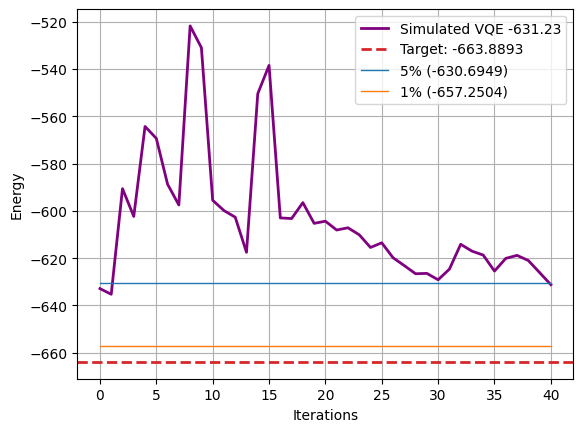

In [49]:
ansatz_opt = l1_result.optimal_circuit
initial_point = l1_result.optimal_point

noisy_sim_results = []
optimizer = get_optimizer(optimizer_type, max_iter = 20 , a = 0.1, c = 0.1)

for resilience_level in range(3):
    noisy_estimator = BackendEstimator(backend = noisy_sim, options = {
        'resilience_level': resilience_level,
        'shots': 4096,
    })

    result_noisy, values = custom_vqe(noisy_estimator, 
                                ansatz_opt, 
                                optimizer, 
                                new_qubit_op,  
                                exact_energy,
                                execution_type,
                                multiplier = None,
                                init_point = initial_point)

    noisy_sim_results.append(result_noisy)

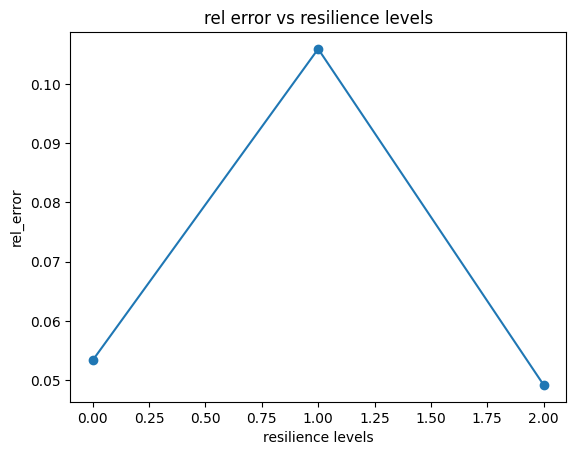

In [50]:
levels = list(range(len(noisy_sim_results)))
rel_errors = [rel_err(exact_energy, res.eigenvalue) for res in noisy_sim_results]
plt.plot(levels, rel_errors, marker='o')
plt.xlabel('resilience levels')
plt.ylabel('rel_error')
plt.title('rel error vs resilience levels');

In [51]:
rel_errors

[0.05335760193199012, 0.10591420964836196, 0.0491940151847935]

## Results with Noisy Sim

The lowest relative error was achieved at `resilience level = 3` with a value of `0.0491940151847935` which is within `5 percent` the actual computed part energy. There is a rise in the relative error with `level=1` which is more than `level=0` (no mitigation). The reason being that with no-mitigation, the result might have found a local minima by chance. We ran it few more times and verified it. We can perform further experiments on this topic on noise mitigation.

We save the hamiltonian for later using it with real hardware.

In [63]:
import pickle 

ops = []
coeffs = []
for op in qubit_op:
    ops.append(op.primitive.paulis[0].__str__())
    coeffs.append(op.primitive.coeffs[0])

h_dict = {
    'ops': ops,
    'coeffs': coeffs
}
    
with open('co2_mn_hamiltonian.pickle', 'wb') as handle:
    pickle.dump(h_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## VQE CO2 @ Cu(|)

We now aim to find the minimum of the PES of a $CO_2$ with $Cu(I)$. From the plots and the dataFrame, we chose the `0.985944 angstorm` as the distance between the $Cu(I)$ metal ion and $CO_2$ oxygen atom. The corresponding CCSD energy is `-49727.239600 eV`. 


We stick to `num_spatial_orbitals = 4` spatial orbitals, we use `SPSA` optimizer for updating the parameters. After `z2 symmetry reduction` the number of hamiltonian terms are `155` and the number of qubits is `5`. The computed Hartree-Fock state is $|10101>$.

In [20]:
df = pd.read_csv('ccsd_reference_potential_energy_curve_cu.csv')
df

,step,root mean square deviation [a0],HF energy [eV],MP2 energy [eV],CCSD energy [eV]
0,0,0.000000,-49696.237282,-49728.097110,-49724.997148
1,1,0.328648,-49698.119366,-49729.538475,-49726.606664
2,2,0.657296,-49698.837048,-49729.972840,-49727.137660
3,3,0.985944,-49699.060045,-49730.024676,-49727.239600
4,4,1.314592,-49699.076908,-49729.939678,-49727.179020
5,5,1.643240,-49699.014461,-49729.813608,-49727.064661
6,6,1.971888,-49698.928951,-49729.683762,-49726.940826
7,7,2.300536,-49698.843709,-49729.564373,-49726.824996
8,8,2.629184,-49698.767040,-49729.460433,-49726.723445
9,9,2.957832,-49698.700910,-49729.372935,-49726.637601


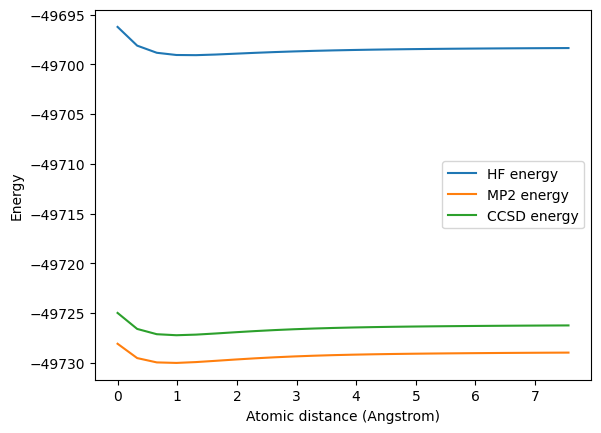

In [21]:
atomic_distance = df[df.keys()[1]]
hf_energy = df[df.keys()[2]]
mp2_energy = df[df.keys()[3]]
ccsd_energy = df[df.keys()[4]]

plt.plot(atomic_distance, hf_energy, label="HF energy")
plt.plot(atomic_distance, mp2_energy, label="MP2 energy")
plt.plot(atomic_distance, ccsd_energy, label="CCSD energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

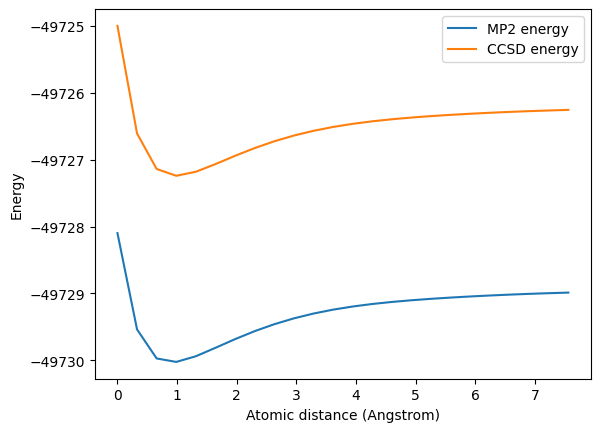

In [22]:
plt.plot(atomic_distance, mp2_energy, label="MP2 energy")
plt.plot(atomic_distance, ccsd_energy, label="CCSD energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [24]:
spin = 0
charge = 1
basis = "ccpvdz"
mapper_type = 'ParityMapper'
ev = 27.2114
min_dist = 0.985944

CO2 = f"C 0.0 0.0 0.0 ; O -{d_co1} 0.0 0.0 ; O {d_co2} 0.0 0.0"
Cu = f"Cu {d_co2 + min_dist} 0.0 0.0"
geometry = f"{CO2} ; {Cu}"

num_spatial_orbitals = 4

# configuration
execution_type = 'local'
z2symmetry_reduction = 'auto'
optimizer_type = 'SPSA'
ansatz_type = 'TwoLocal'
reps = 1

In [25]:
problem_reduced, converter, qubit_op, res_actual = construct_problem( geometry, 
                                                                      charge, 
                                                                      spin, 
                                                                      basis, 
                                                                      mapper_type,
                                                                      num_spatial_orbitals,
                                                                      num_electrons = None, 
                                                                      z2symmetry_reduction=z2symmetry_reduction)
exact_energy = res_actual.eigenvalues[0]

In [26]:
print(f'Expected ground state energy: {exact_energy:.12f}')

Expected ground state energy: -1029.241990884978


In [64]:
print(res_actual)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2086.990348710701
  - computed part:      -1029.241990884978
  - ActiveSpaceTransformer extracted energy part: -1057.748357825723
~ Nuclear repulsion energy (Hartree): 262.099737482148
> Total ground state energy (Hartree): -1824.890611228553
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 8.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [118.11031382  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [114.63874469  None  None]
    - computed part:      [32.58176552  None  None]
    - ActiveSpaceTransformer extracted energy part: [82.05697917  0.0  0.0]
  > Dipole moment (a.u.): [3.47156913  None  None]  Total: None
                 (debye): [8.82384775  None  None]  Total: None
 


In [27]:
len(qubit_op), qubit_op.num_qubits

(155, 5)

In [28]:
ansatz = get_ansatz(ansatz_type, reps, problem_reduced, converter)
ansatz_opt, new_qubit_op = device_mapping(ansatz, noisy_sim, qubit_op)

In [44]:
ansatz.decompose().draw(fold = 200)

┌───────────┐┌──────────┐     ┌──────────┐                                    
q_0: ┤ U3(π,0,π) ├┤ Ry(θ[0]) ├──■──┤ Ry(θ[5]) ├────────────────────────────────────
     └┬──────────┤└──────────┘┌─┴─┐└──────────┘┌──────────┐                        
q_1: ─┤ Ry(θ[1]) ├────────────┤ X ├─────■──────┤ Ry(θ[6]) ├────────────────────────
     ┌┴──────────┤┌──────────┐└───┘   ┌─┴─┐    └──────────┘┌──────────┐            
q_2: ┤ U3(π,0,π) ├┤ Ry(θ[2]) ├────────┤ X ├─────────■──────┤ Ry(θ[7]) ├────────────
     └┬──────────┤└──────────┘        └───┘       ┌─┴─┐    └──────────┘┌──────────┐
q_3: ─┤ Ry(θ[3]) ├────────────────────────────────┤ X ├─────────■──────┤ Ry(θ[8]) ├
     ┌┴──────────┤┌──────────┐                    └───┘       ┌─┴─┐    ├──────────┤
q_4: ┤ U3(π,0,π) ├┤ Ry(θ[4]) ├────────────────────────────────┤ X ├────┤ Ry(θ[9]) ├
     └───────────┘└──────────┘                                └───┘    └──────────┘

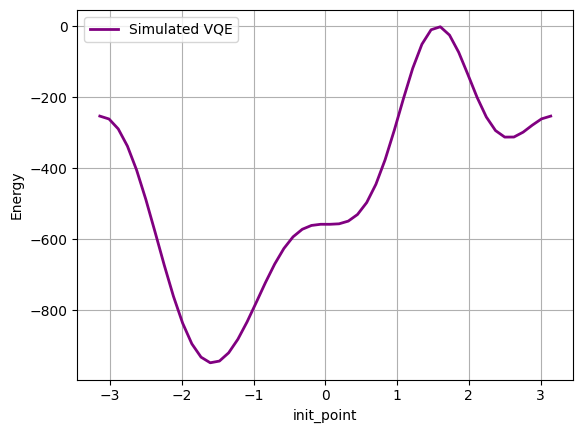

In [33]:
multiplier = init_point_finder(ansatz_opt, optimizer_type, new_qubit_op)

In [34]:
multiplier

-1.60285339468867

In [37]:
optimizer = get_optimizer(optimizer_type, max_iter =150 , a = 0.01, c = 0.02)

estimator = Estimator(
        options = {
            "method": "density_matrix",
            "coupling_map": coupling_map,
            "seed": seed, 
            "seed_transpiler": seed,
            "optimization_level":0,
        }
    )

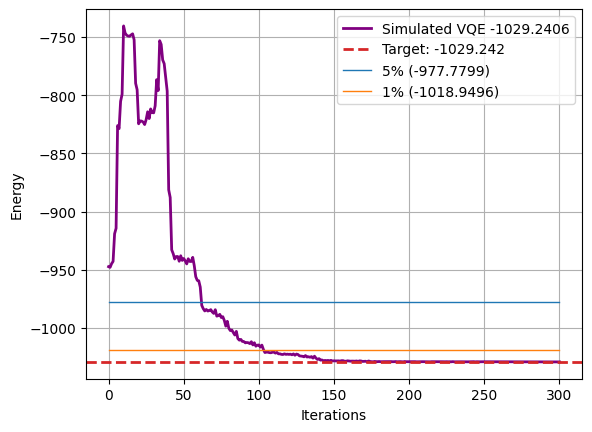

In [38]:
result, values = custom_vqe(estimator, 
                            ansatz_opt, 
                            optimizer, 
                            new_qubit_op,  
                            exact_energy,
                            execution_type,
                            multiplier)

In [46]:
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 300,
    'eigenvalue': -1029.2405952587992,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f1861eb80a0>,
    'optimal_parameters': {   ParameterVectorElement(θ[3]): -1.571152426993436,
                              ParameterVectorElement(θ[9]): -1.57405242165707,
                              ParameterVectorElement(θ[5]): -5.385221532780669,
                              ParameterVectorElement(θ[1]): -1.569883407514803,
                              ParameterVectorElement(θ[7]): -1.5717288444705984,
                              ParameterVectorElement(θ[8]): -1.5694059469748967,
                              ParameterVectorElement(θ[4]): -1.5708504174648332,
                              ParameterVectorElement(θ[2]): -1.5704969257061727,
                              ParameterVectorElement(θ[6]): -1.5715747138643186,
                              ParameterVectorElement(θ[0]): -2.236843259

In [52]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(exact_energy, result.eigenvalue)

print(f'Expected ground state energy: {exact_energy:.12f}')
print(f'Computed ground state energy: {result.eigenvalue:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -1029.241990884978
Computed ground state energy: -1029.240595258799
Relative error: 0.000001355975


## Results

We run the algorithm with 150 iterations. The algorithm sucessufully converges to the `computed part energy` in ~35 seconds with a relative error of `0.000001355975` that is within $10^{-5}$ Hartree.

The relative error of `VQE's ground state energy` with the `ground state energy of the NumPyMinimumEigensolver` is `0.000000765` which is within $10^{-6}$.

The relative error of `VQE's ground state energy` with the `classical reference solution` is `0.001396603` which is within $10^{-2}$.

### Deparameterisation

Again most the parameters ( parameters 1,2,3,4,6,7,8 and 9 to be specific) are in the vicinity of $-\pi/2$. We freeze these parameters and now we are left with only 2 parameters to optimize for. The optimization needed on 40 iterations (~ 9 seconds,  a `74.2 percent` decrease in the runtime) with a relative errror of `0.000000040533` (`97 percent` decrease).

The relative error of `VQE's ground state energy` with the `classical reference solution` is `0.001395862` (a `0.053 percent` decrease).

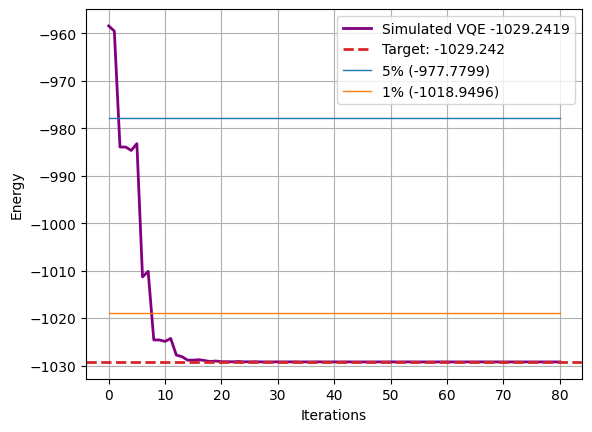

In [54]:
optimizer = get_optimizer(optimizer_type, max_iter = 40 , a = 0.01, c = 0.01)
tqc = deparameterise(result.optimal_circuit,
                     result.optimal_parameters,
                     [1,2,3,4,6,7,8,9], -np.pi/2)

l1_result, values = custom_vqe(estimator, 
                                tqc, 
                                optimizer, 
                                new_qubit_op,  
                                exact_energy,
                                execution_type,
                                multiplier = None)

In [55]:
print(l1_result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 80,
    'eigenvalue': -1029.2419491668345,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f1906c03430>,
    'optimal_parameters': {   ParameterVectorElement(θ[5]): -1.1838722947860942,
                              ParameterVectorElement(θ[0]): 1.9562821031668052},
    'optimal_point': array([ 1.9562821 , -1.18387229]),
    'optimal_value': -1029.2419491668345,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7f1905927d90>,
    'optimizer_time': 8.540244579315186}


In [56]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(exact_energy, l1_result.eigenvalue)

print(f'Expected ground state energy: {exact_energy:.12f}')
print(f'Computed ground state energy: {l1_result.eigenvalue:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -1029.241990884978
Computed ground state energy: -1029.241949166835
Relative error: 0.000000040533


## Noisy Sim

We test the reduced parameter circuit with the noisy sim as backend. We try different error mitigation schemes which is controlled by the parameter `resilience level`.

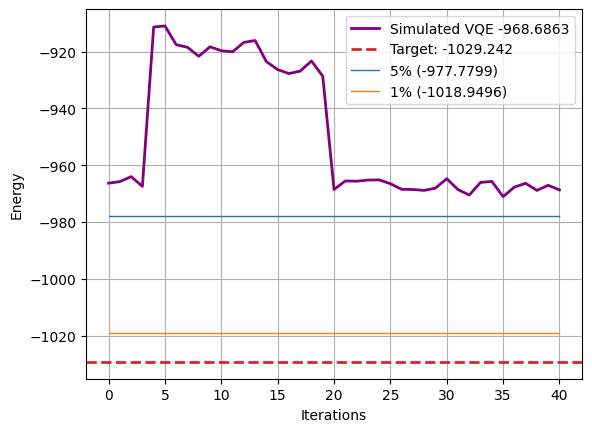

In [58]:
ansatz_opt = l1_result.optimal_circuit
initial_point = l1_result.optimal_point

noisy_sim_results = []
optimizer = get_optimizer(optimizer_type, max_iter = 20 , a = 0.01, c = 0.01)

for resilience_level in range(3):
    noisy_estimator = BackendEstimator(backend = noisy_sim, options = {
        'resilience_level': resilience_level,
        'shots': 4096,
    })

    result_noisy, values = custom_vqe(noisy_estimator, 
                                ansatz_opt, 
                                optimizer, 
                                new_qubit_op,  
                                exact_energy,
                                execution_type,
                                multiplier = None,
                                init_point = initial_point)

    noisy_sim_results.append(result_noisy)

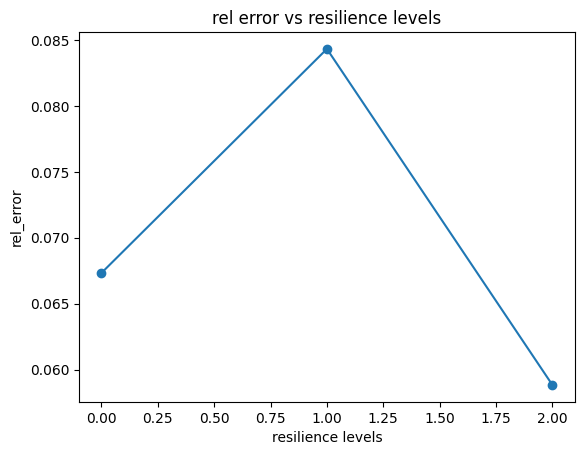

In [59]:
levels = list(range(len(noisy_sim_results)))
rel_errors = [rel_err(exact_energy, res.eigenvalue) for res in noisy_sim_results]
plt.plot(levels, rel_errors, marker='o')
plt.xlabel('resilience levels')
plt.ylabel('rel_error')
plt.title('rel error vs resilience levels');

In [60]:
rel_errors

[0.06733144001057519, 0.0843297604405736, 0.058835195695390405]

## Results with Noisy Sim

The lowest relative error was achieved at `resilience level = 3` with a value of `0.058835195695390405` which is within `6 percent` the actual computed part energy. A similar trend is seen here as with $Mn(II)$ (rise in the relative error with `level=1` which is more than `level=0` (no mitigation)).

## What's next?

In the other notebook we take the VQE on the real hardware for $CO_2 @ Mn(II)$ system. We use [pennylane](https://pennylane.ai/) for this purpose and it has [pennylane-braket-plugin](https://amazon-braket-pennylane-plugin-python.readthedocs.io/en/latest/).